In [1]:
import sys
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from IPython.display import HTML, display
from matplotlib import cm
from matplotlib.colors import ListedColormap
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# Load the DataFrames
train_features_file = Path("data/train_features.parquet")
if train_features_file.exists:
    train_df = pl.read_parquet(train_features_file, use_pyarrow=True, memory_map=True)
else:
    print(f"Train Features File is missing {train_features_file}", file=sys.stderr)
    exit()
test_features_file = Path("data/test_features.parquet")
if test_features_file.exists:
    test_df = pl.read_parquet(test_features_file, use_pyarrow=True, memory_map=True)
else:
    print(f"Test Features File is missing {test_features_file}", file=sys.stderr)
    exit()

meta_file = Path("data/meta_full.parquet")
if meta_file.exists:
    meta_df = pl.read_parquet(meta_file, use_pyarrow=True, memory_map=True)
else:
    print(f"Meta File is missing {meta_file}", file=sys.stderr)
    exit()

In [3]:
samples_per_class = 200
random_seed = 42
train_sampled_df = pl.concat(
    [
        x.sample(samples_per_class, with_replacement=False, seed=random_seed)
        for x in train_df.partition_by("ClassId")
    ]
)

In [4]:
X_train_LBP = np.asarray(train_sampled_df["LBP_Hist"].to_list())
X_test_LBP = np.asarray(test_df["LBP_Hist"].to_list())

In [5]:
X_train_Hue = np.asarray(train_sampled_df["Hue_Hist"].to_list())
X_train_Saturation = np.asarray(train_sampled_df["Saturation_Hist"].to_list())
X_train_Value = np.asarray(train_sampled_df["Value_Hist"].to_list())
X_train_HSV = np.concatenate((X_train_Hue, X_train_Saturation, X_train_Value), axis=1)

X_test_Hue = np.asarray(test_df["Hue_Hist"].to_list())
X_test_Saturation = np.asarray(test_df["Saturation_Hist"].to_list())
X_test_Value = np.asarray(test_df["Value_Hist"].to_list())
X_test_HSV = np.concatenate((X_test_Hue, X_test_Saturation, X_test_Value), axis=1)

In [6]:
X_train_HOG = np.asarray(train_sampled_df["HOG_Features"].to_list())
X_test_HOG = np.asarray(test_df["HOG_Features"].to_list())

In [7]:
X_train = X_train_HOG
X_test = X_test_HOG

In [8]:
y_train = train_sampled_df["ClassId"].to_numpy()
y_test = test_df["ClassId"].to_numpy()

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
svm_classifier = SVC(
    kernel="linear", degree=4, C=1.0, random_state=42
)  # linear, poly, rbf
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

In [11]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9283452098178939


In [12]:
confusion_matrix_result = confusion_matrix(y_test, y_pred)

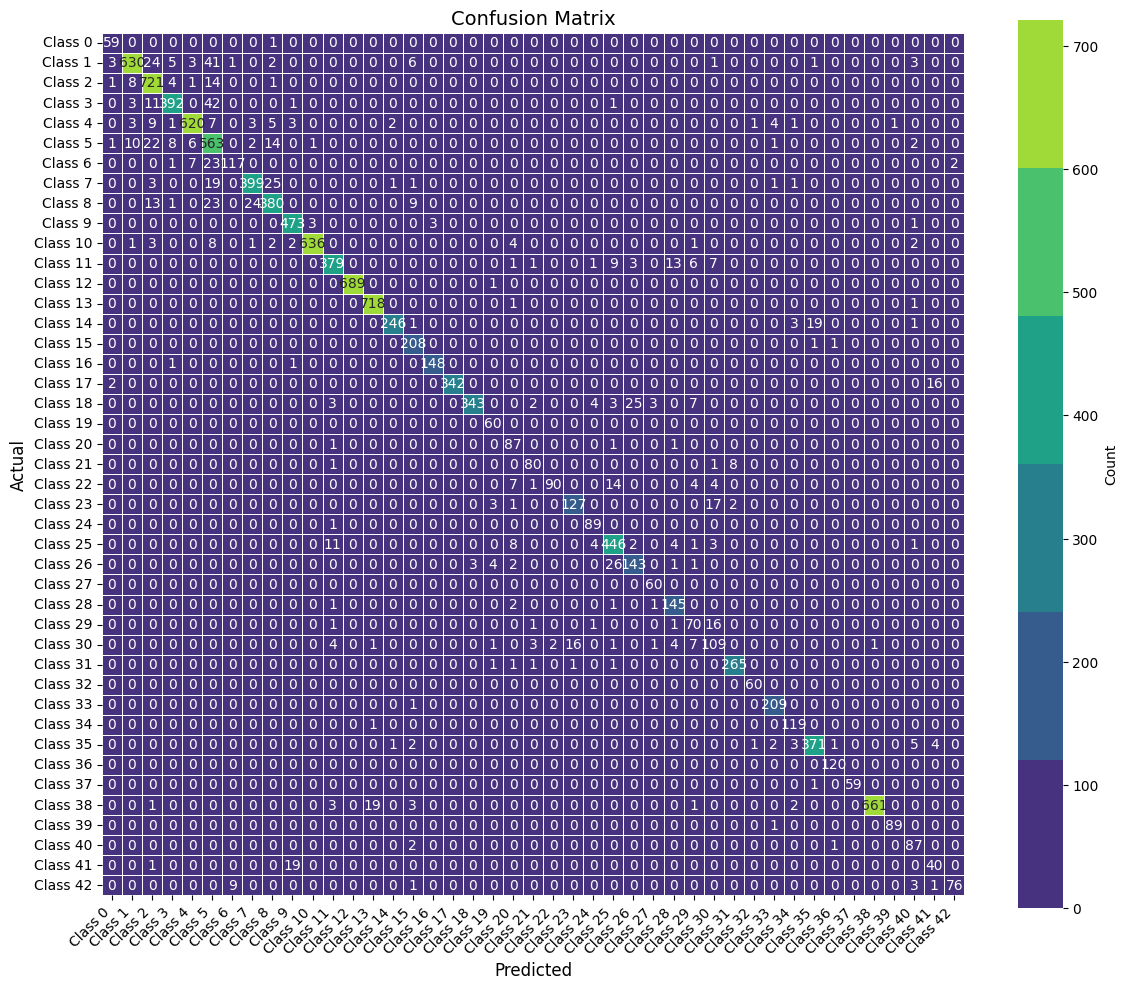

In [13]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(12, 10))

class_labels = [f"Class {i}" for i in range(43)]

# Use seaborn's heatmap with a diverging color palette
cmap = ListedColormap(sns.color_palette("viridis"))
sns.heatmap(
    confusion_matrix_result,
    annot=True,
    fmt="d",
    cmap=cmap,
    linewidths=0.5,
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=class_labels,
    yticklabels=class_labels,
    annot_kws={"size": 10},
)

# Customize labels and title
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Adjust layout to prevent cutoff of labels
plt.tight_layout()

# Show the plot
plt.show()

In [14]:
report = classification_report(y_test, y_pred)


def display_classification_report(report):
    report_html = HTML(f"<pre>{report}</pre>")
    display(report_html)


# Display the formatted classification report
display_classification_report(report)

In [15]:
misclassified_indices = np.where(y_test != y_pred)[0]

confused_counts = {}
confused_index_dict = {}
for i in misclassified_indices:
    true_label = y_test[i]
    predicted_label = y_pred[i]

    # Use a tuple to represent the pair of true and predicted labels
    label_pair = (true_label, predicted_label)

    # Increment the count for the label pair
    confused_counts[label_pair] = confused_counts.get(label_pair, 0) + 1
    if label_pair not in confused_index_dict:
        confused_index_dict[label_pair] = []
    confused_index_dict[label_pair].append(int(i))

# Print the top 10 most confused items and their counts
top_10_confused_counts = sorted(
    confused_counts.items(), key=lambda x: x[1], reverse=True
)[:20]

for label_pair, count in top_10_confused_counts:
    true_label, predicted_label = label_pair
    print(
        f"True Label: {true_label:2d},\tPredicted Label: {predicted_label:2d},\tCount: {count:2d}"
    )

True Label:  3,	Predicted Label:  5,	Count: 42
True Label:  1,	Predicted Label:  5,	Count: 41
True Label: 26,	Predicted Label: 25,	Count: 26
True Label: 18,	Predicted Label: 26,	Count: 25
True Label:  7,	Predicted Label:  8,	Count: 25
True Label:  1,	Predicted Label:  2,	Count: 24
True Label:  8,	Predicted Label:  7,	Count: 24
True Label:  8,	Predicted Label:  5,	Count: 23
True Label:  6,	Predicted Label:  5,	Count: 23
True Label:  5,	Predicted Label:  2,	Count: 22
True Label: 41,	Predicted Label:  9,	Count: 19
True Label: 38,	Predicted Label: 13,	Count: 19
True Label:  7,	Predicted Label:  5,	Count: 19
True Label: 14,	Predicted Label: 35,	Count: 19
True Label: 23,	Predicted Label: 30,	Count: 17
True Label: 30,	Predicted Label: 23,	Count: 16
True Label: 29,	Predicted Label: 30,	Count: 16
True Label: 17,	Predicted Label: 41,	Count: 16
True Label:  5,	Predicted Label:  8,	Count: 14
True Label: 22,	Predicted Label: 25,	Count: 14


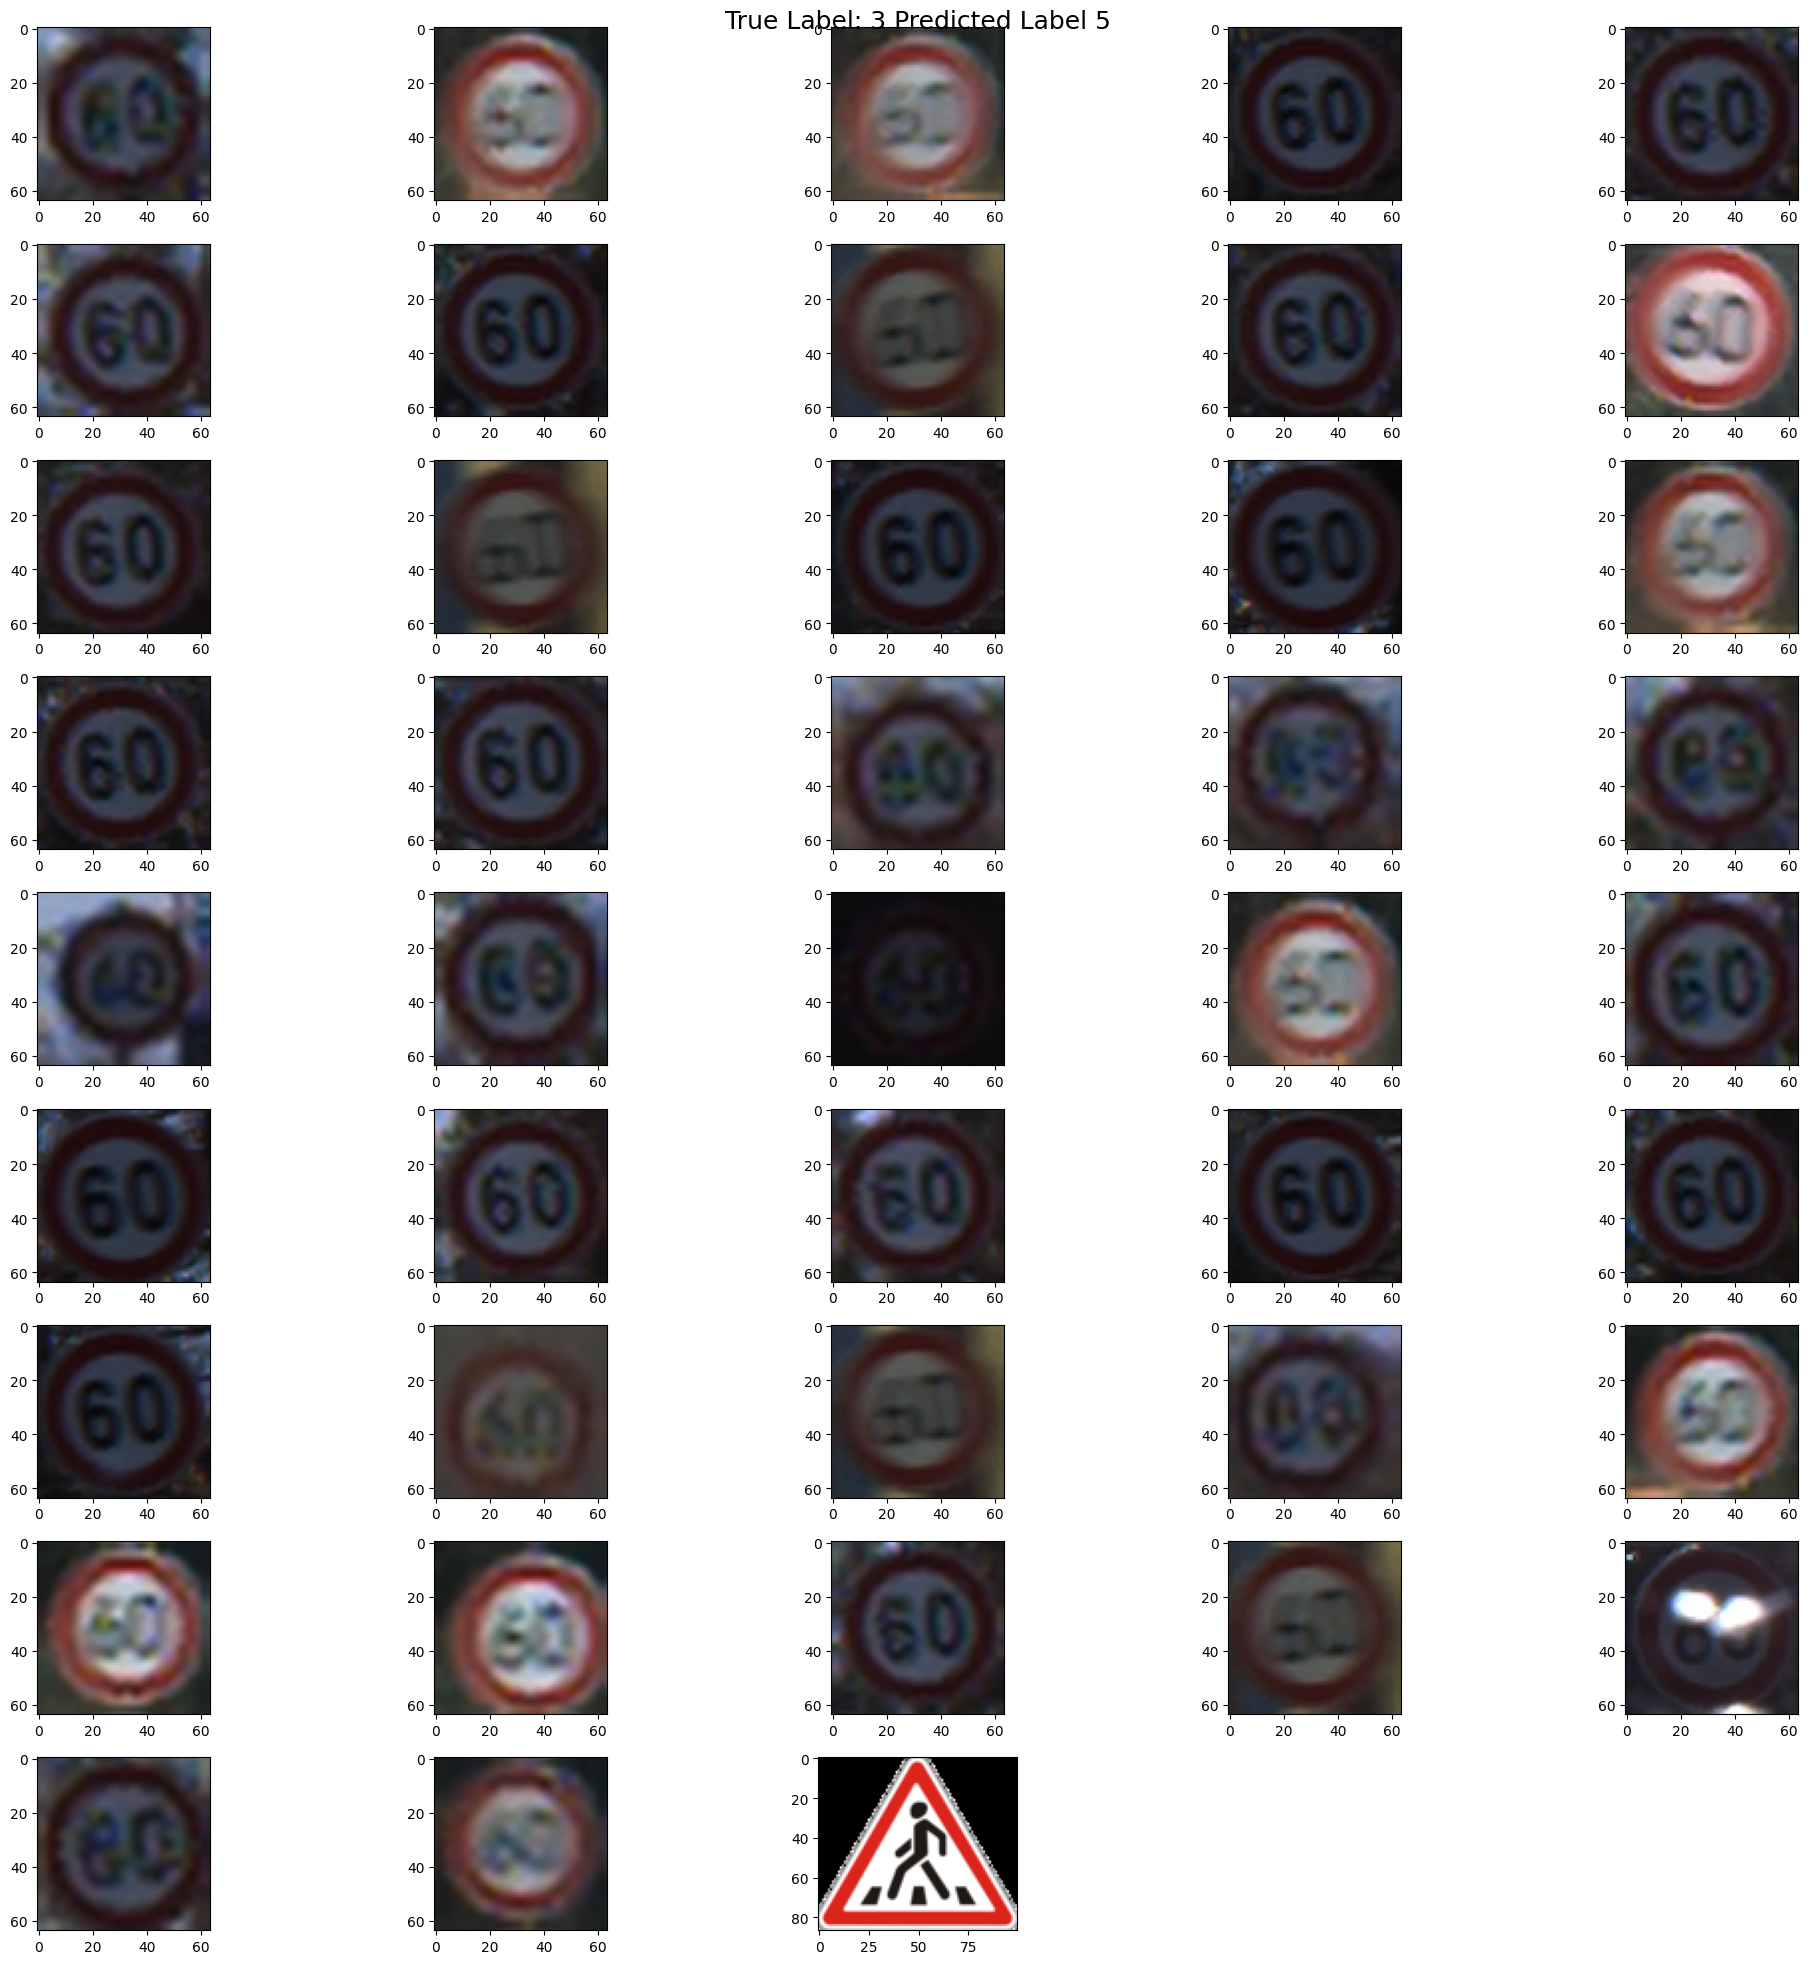

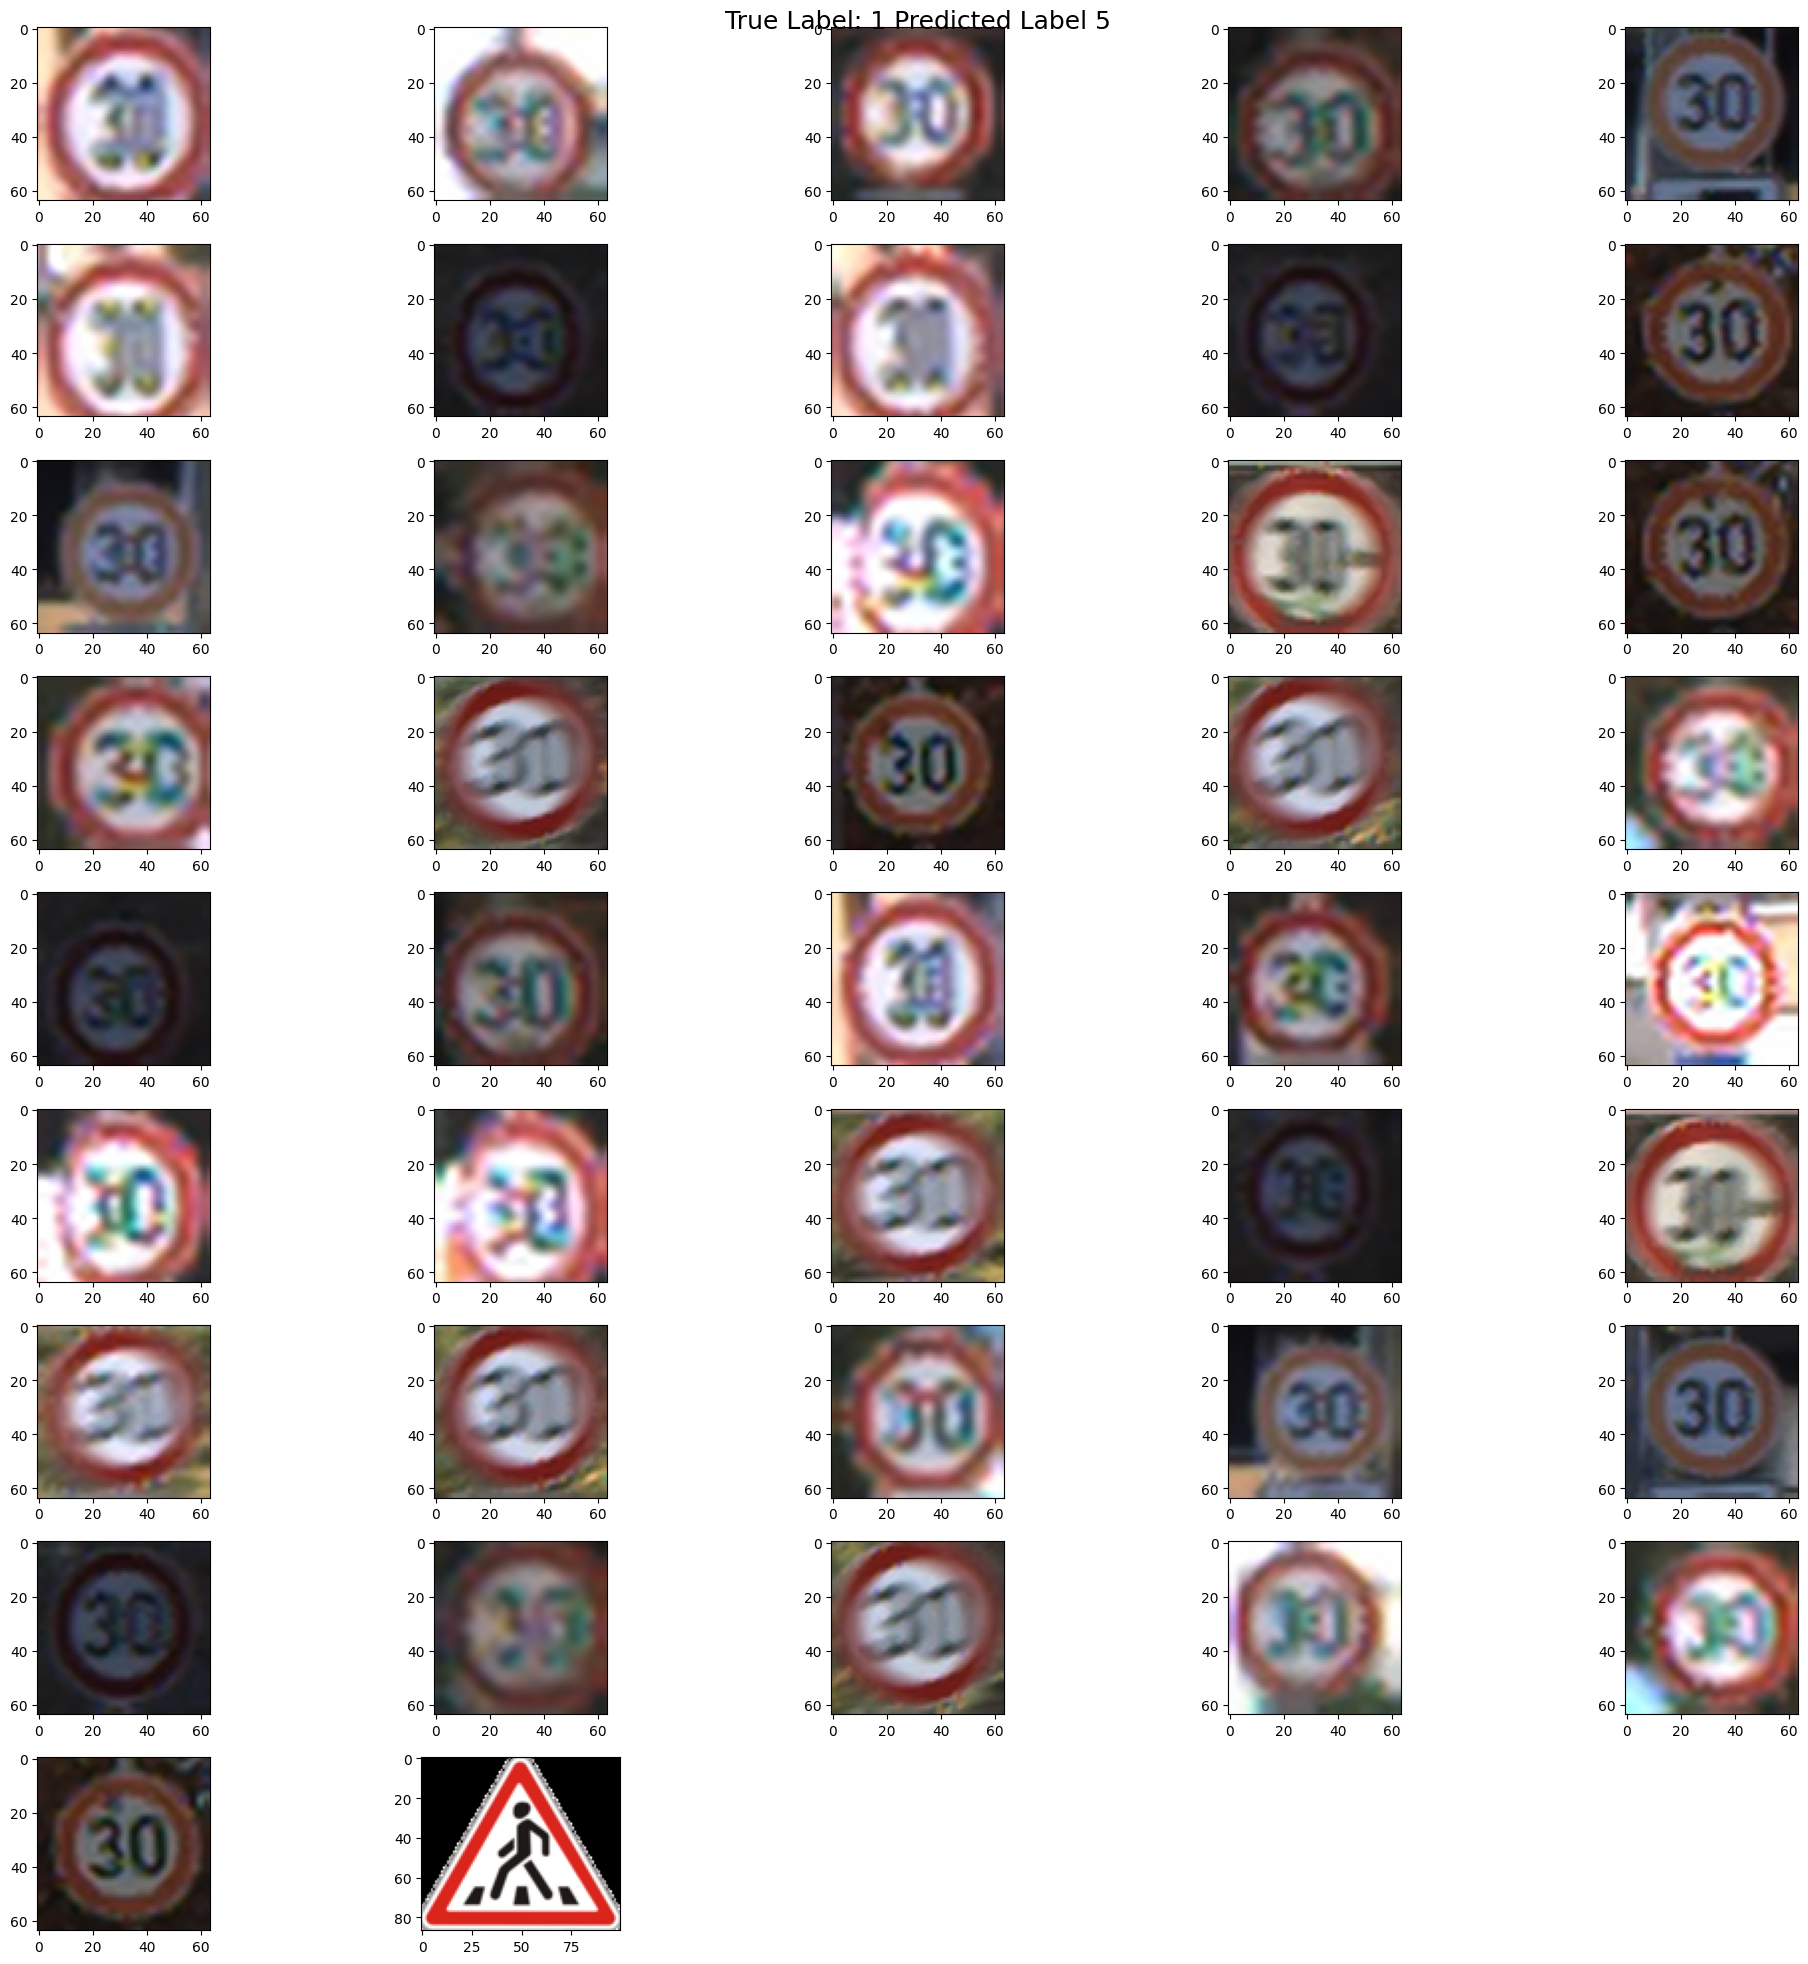

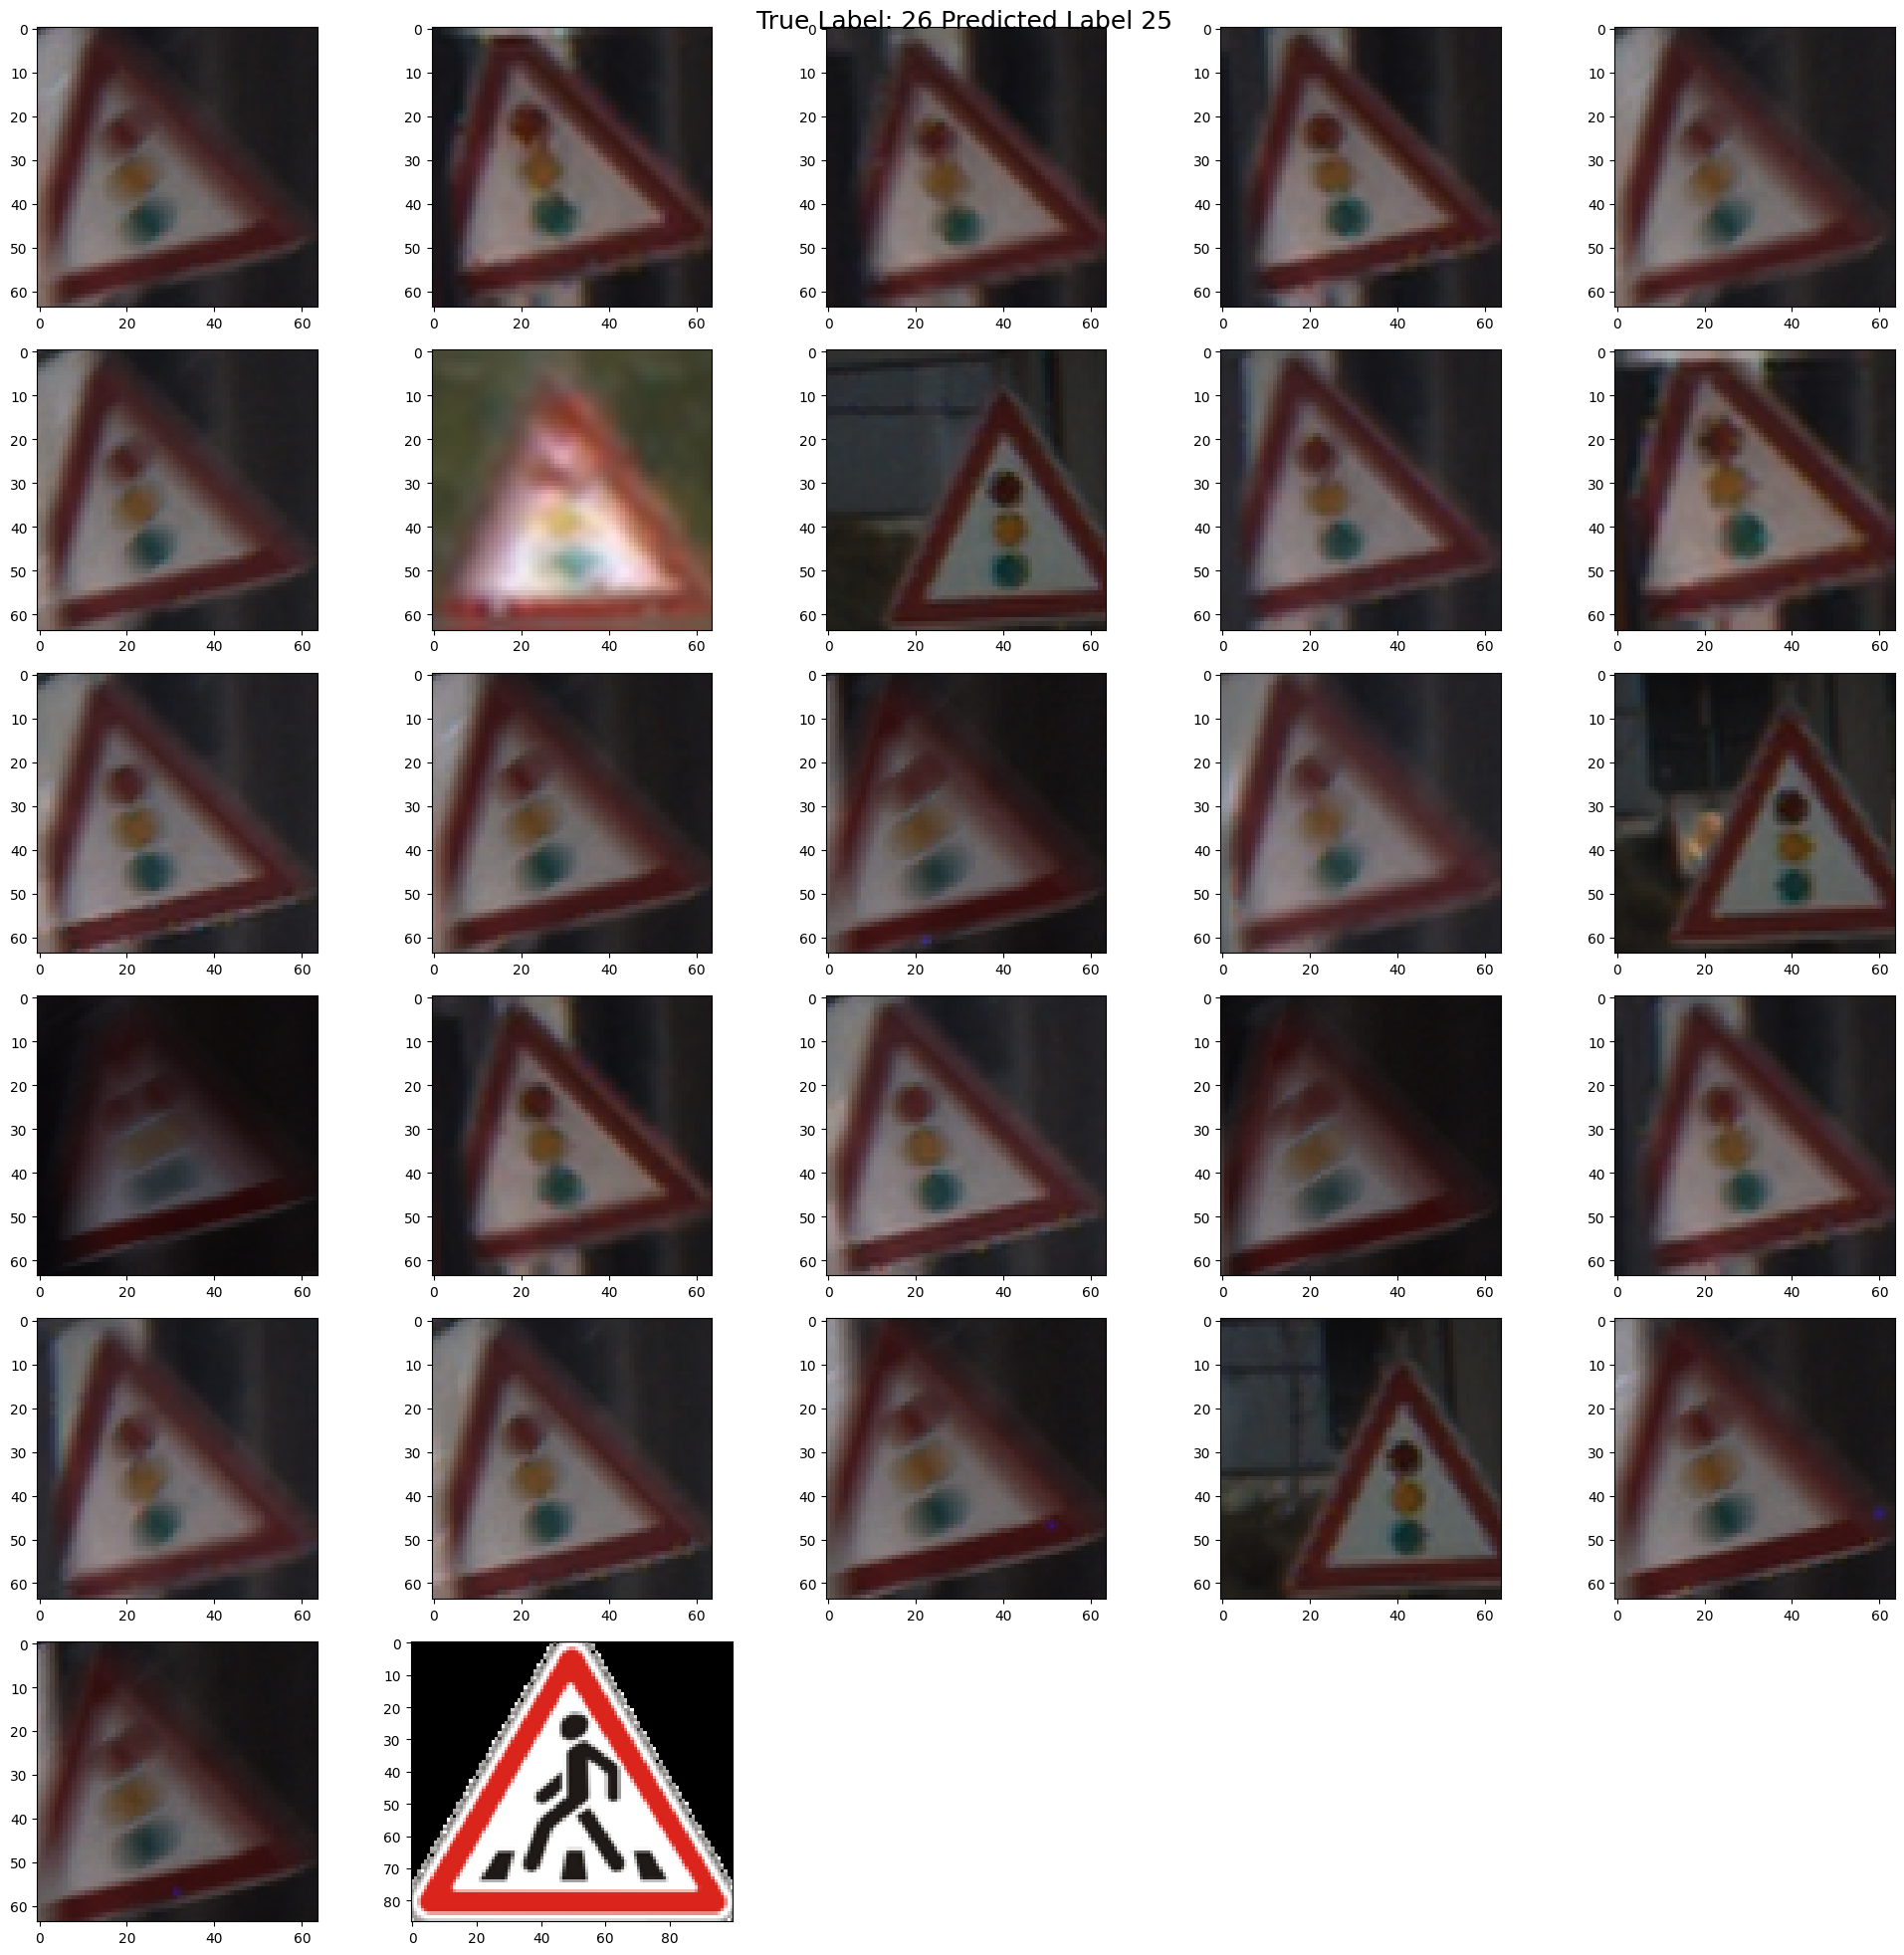

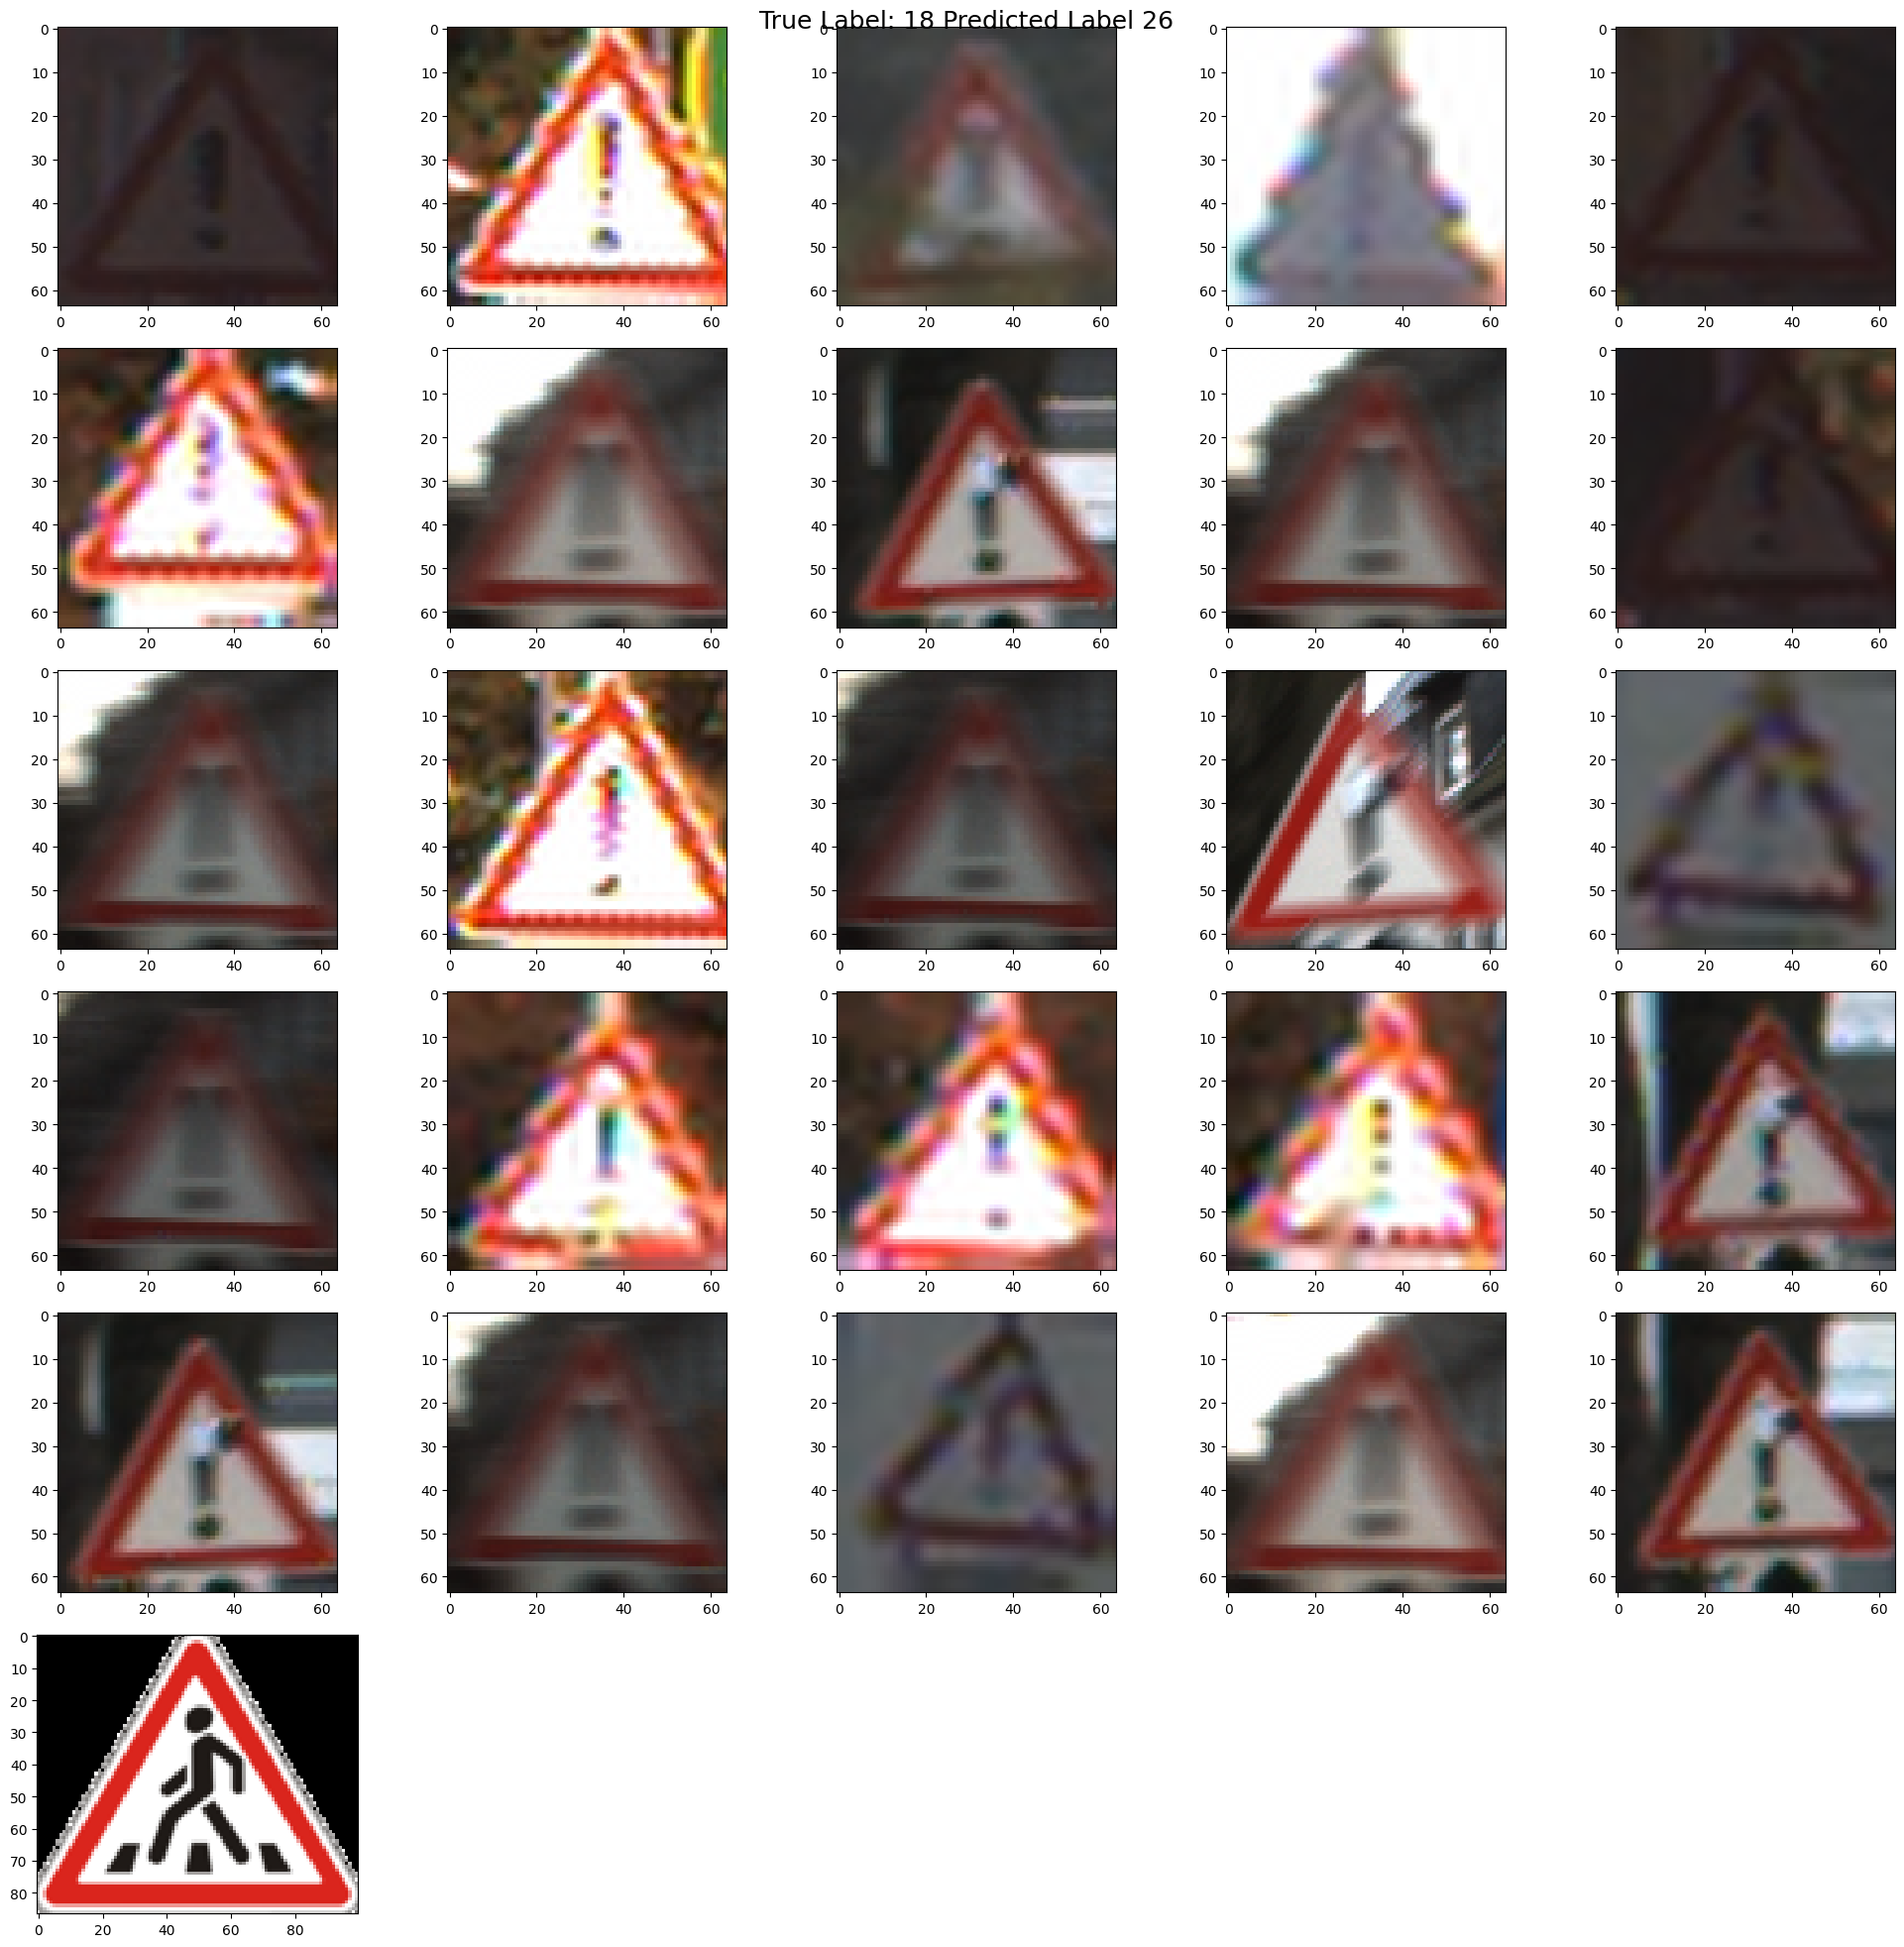

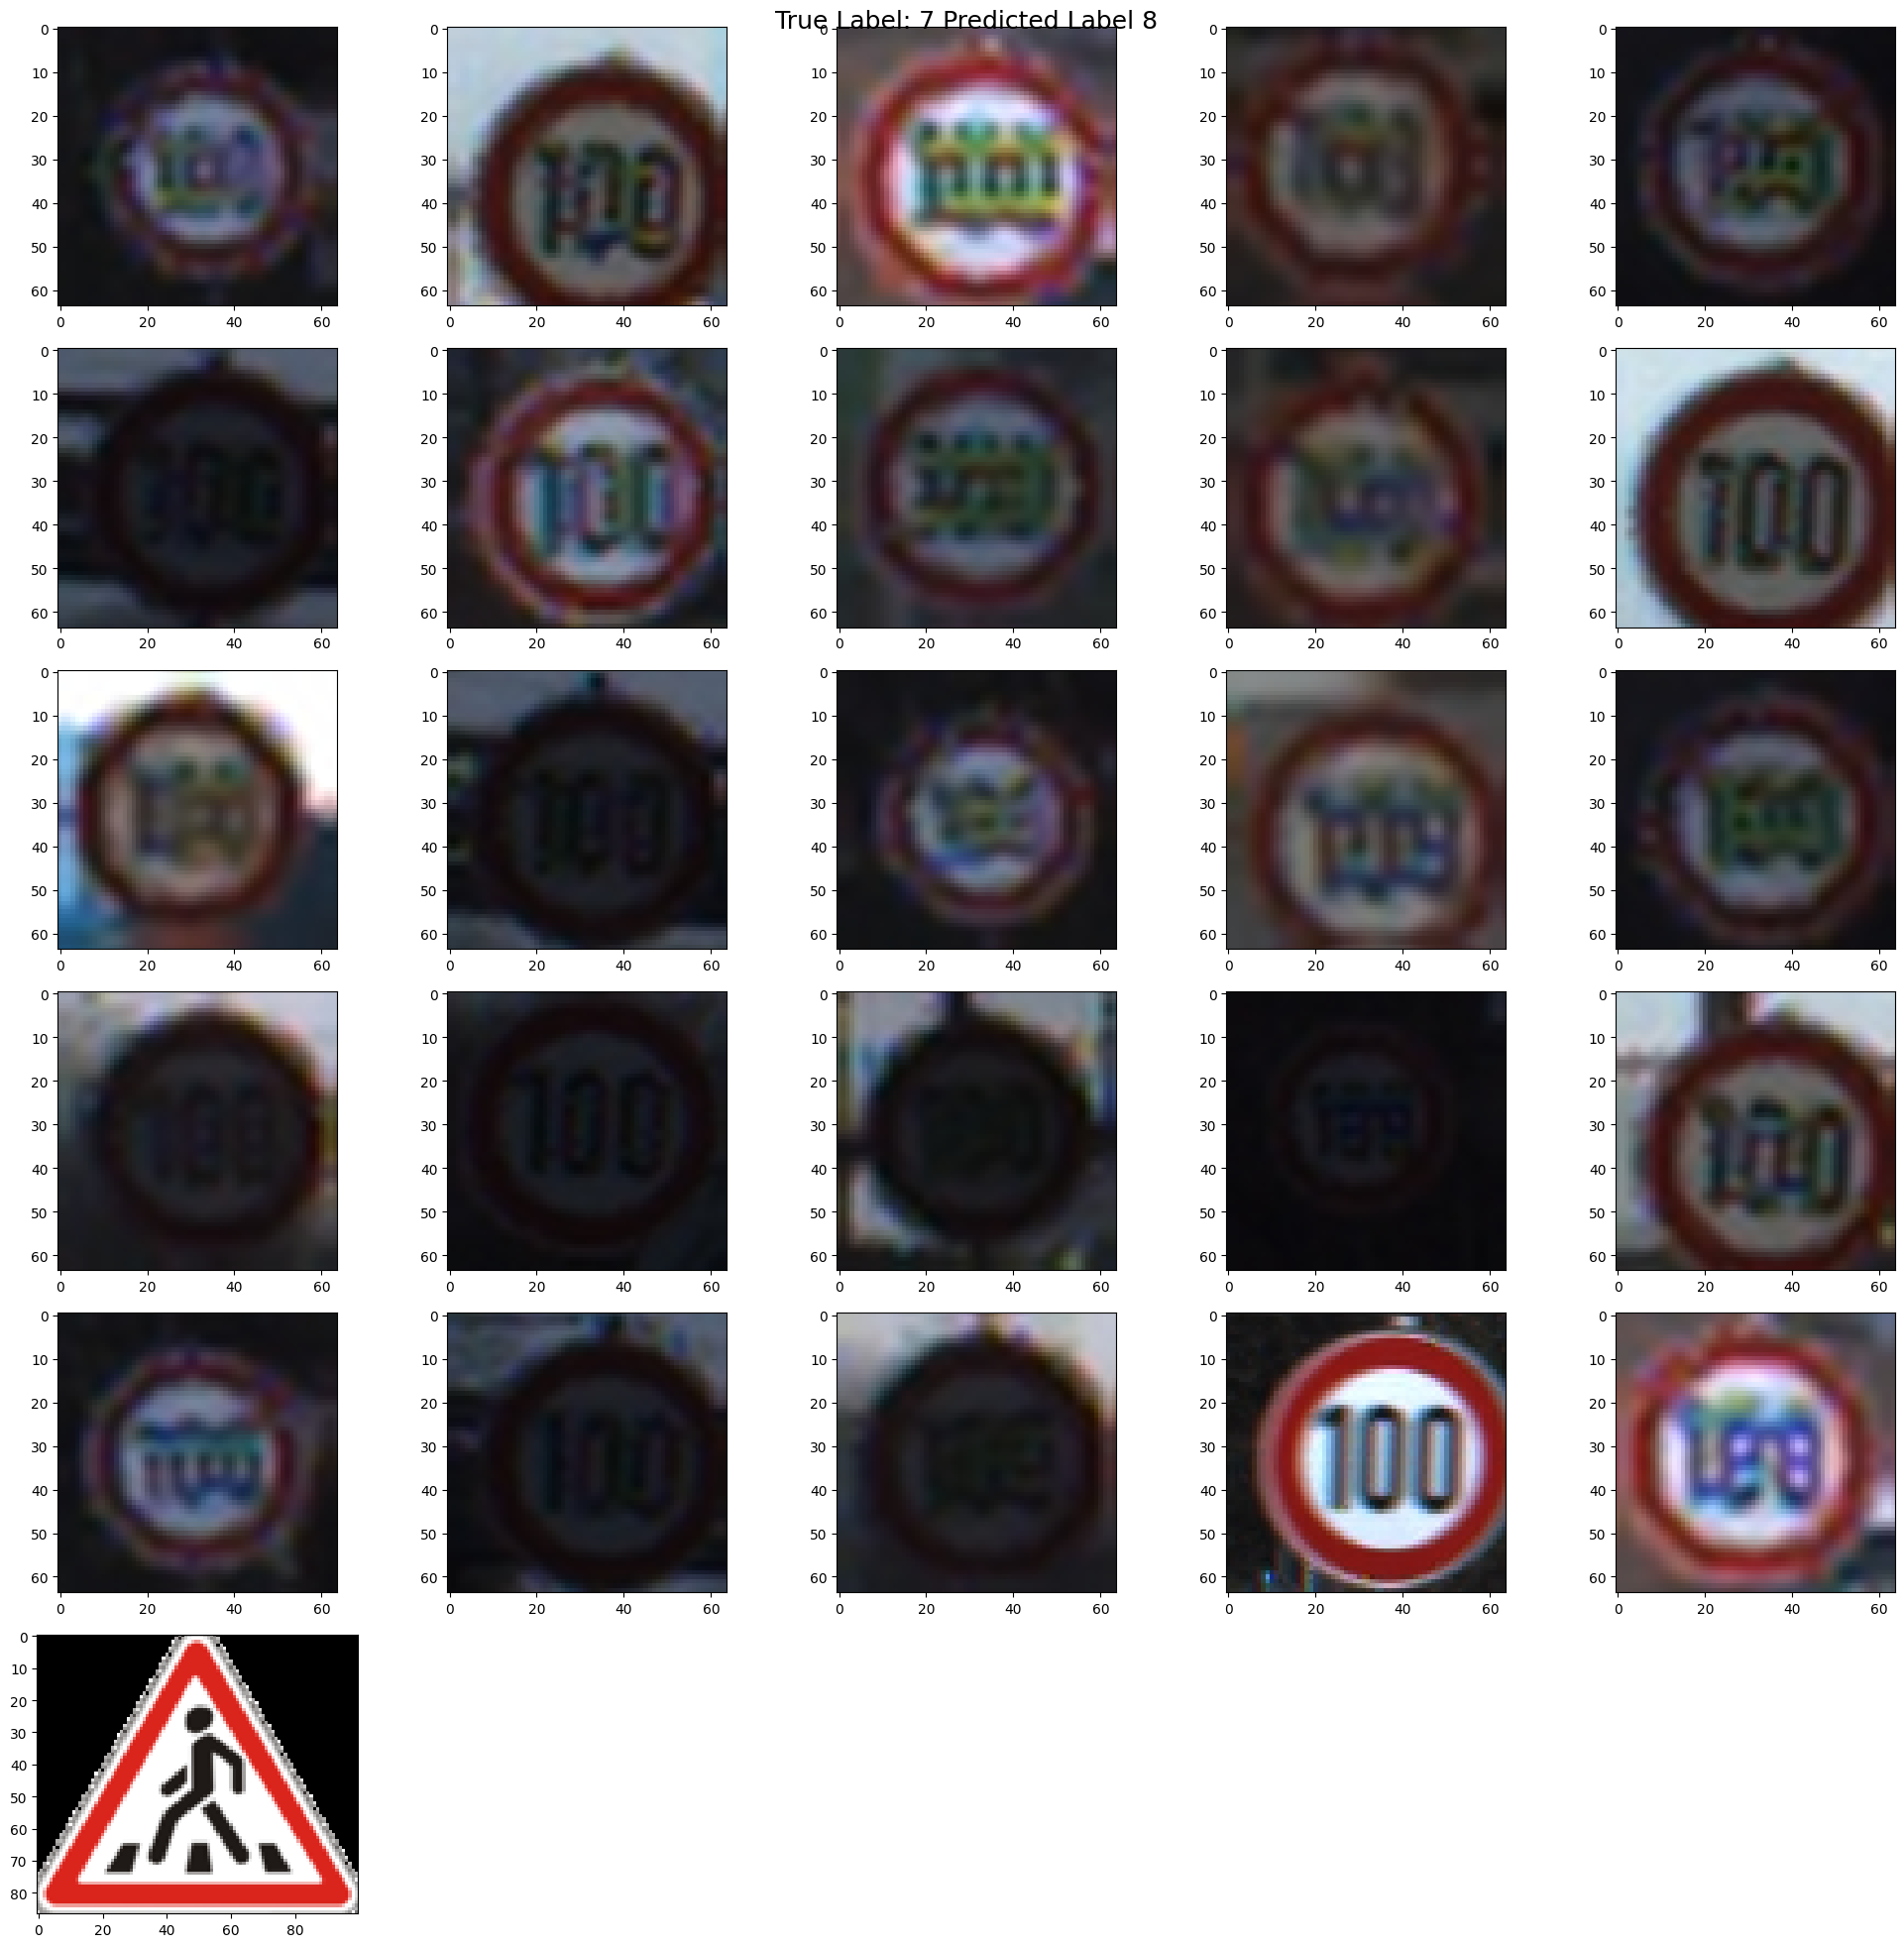

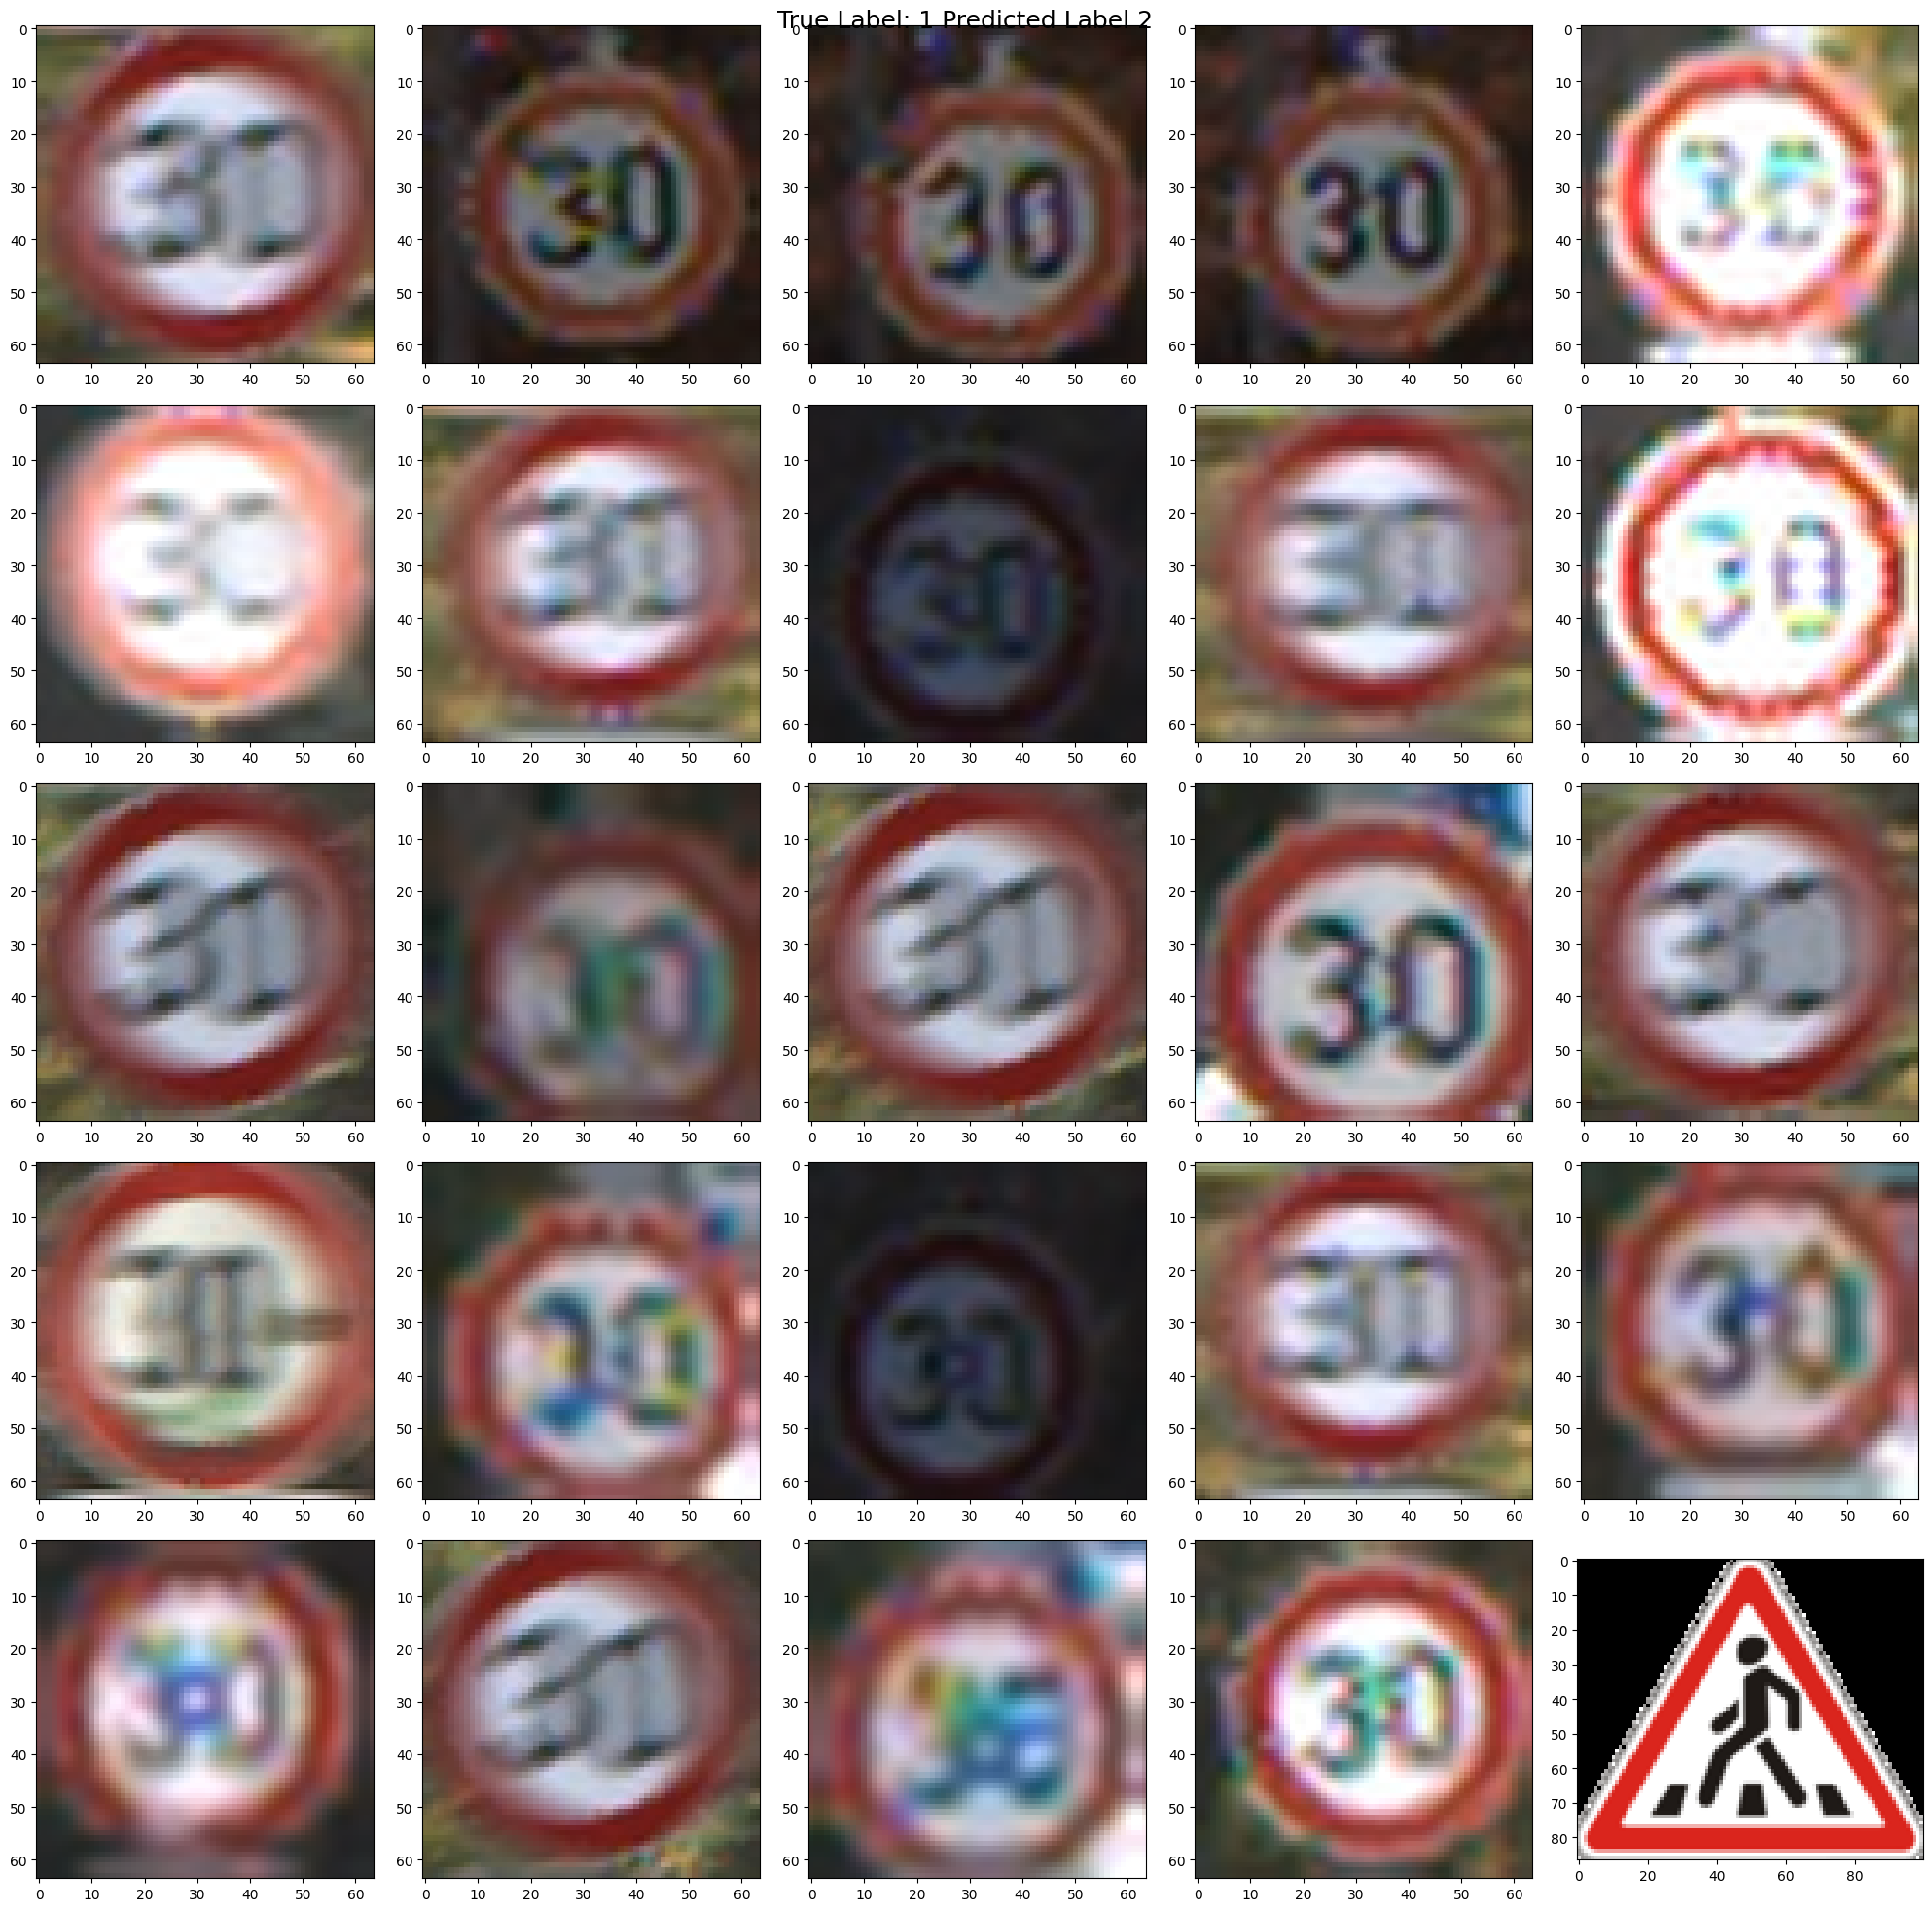

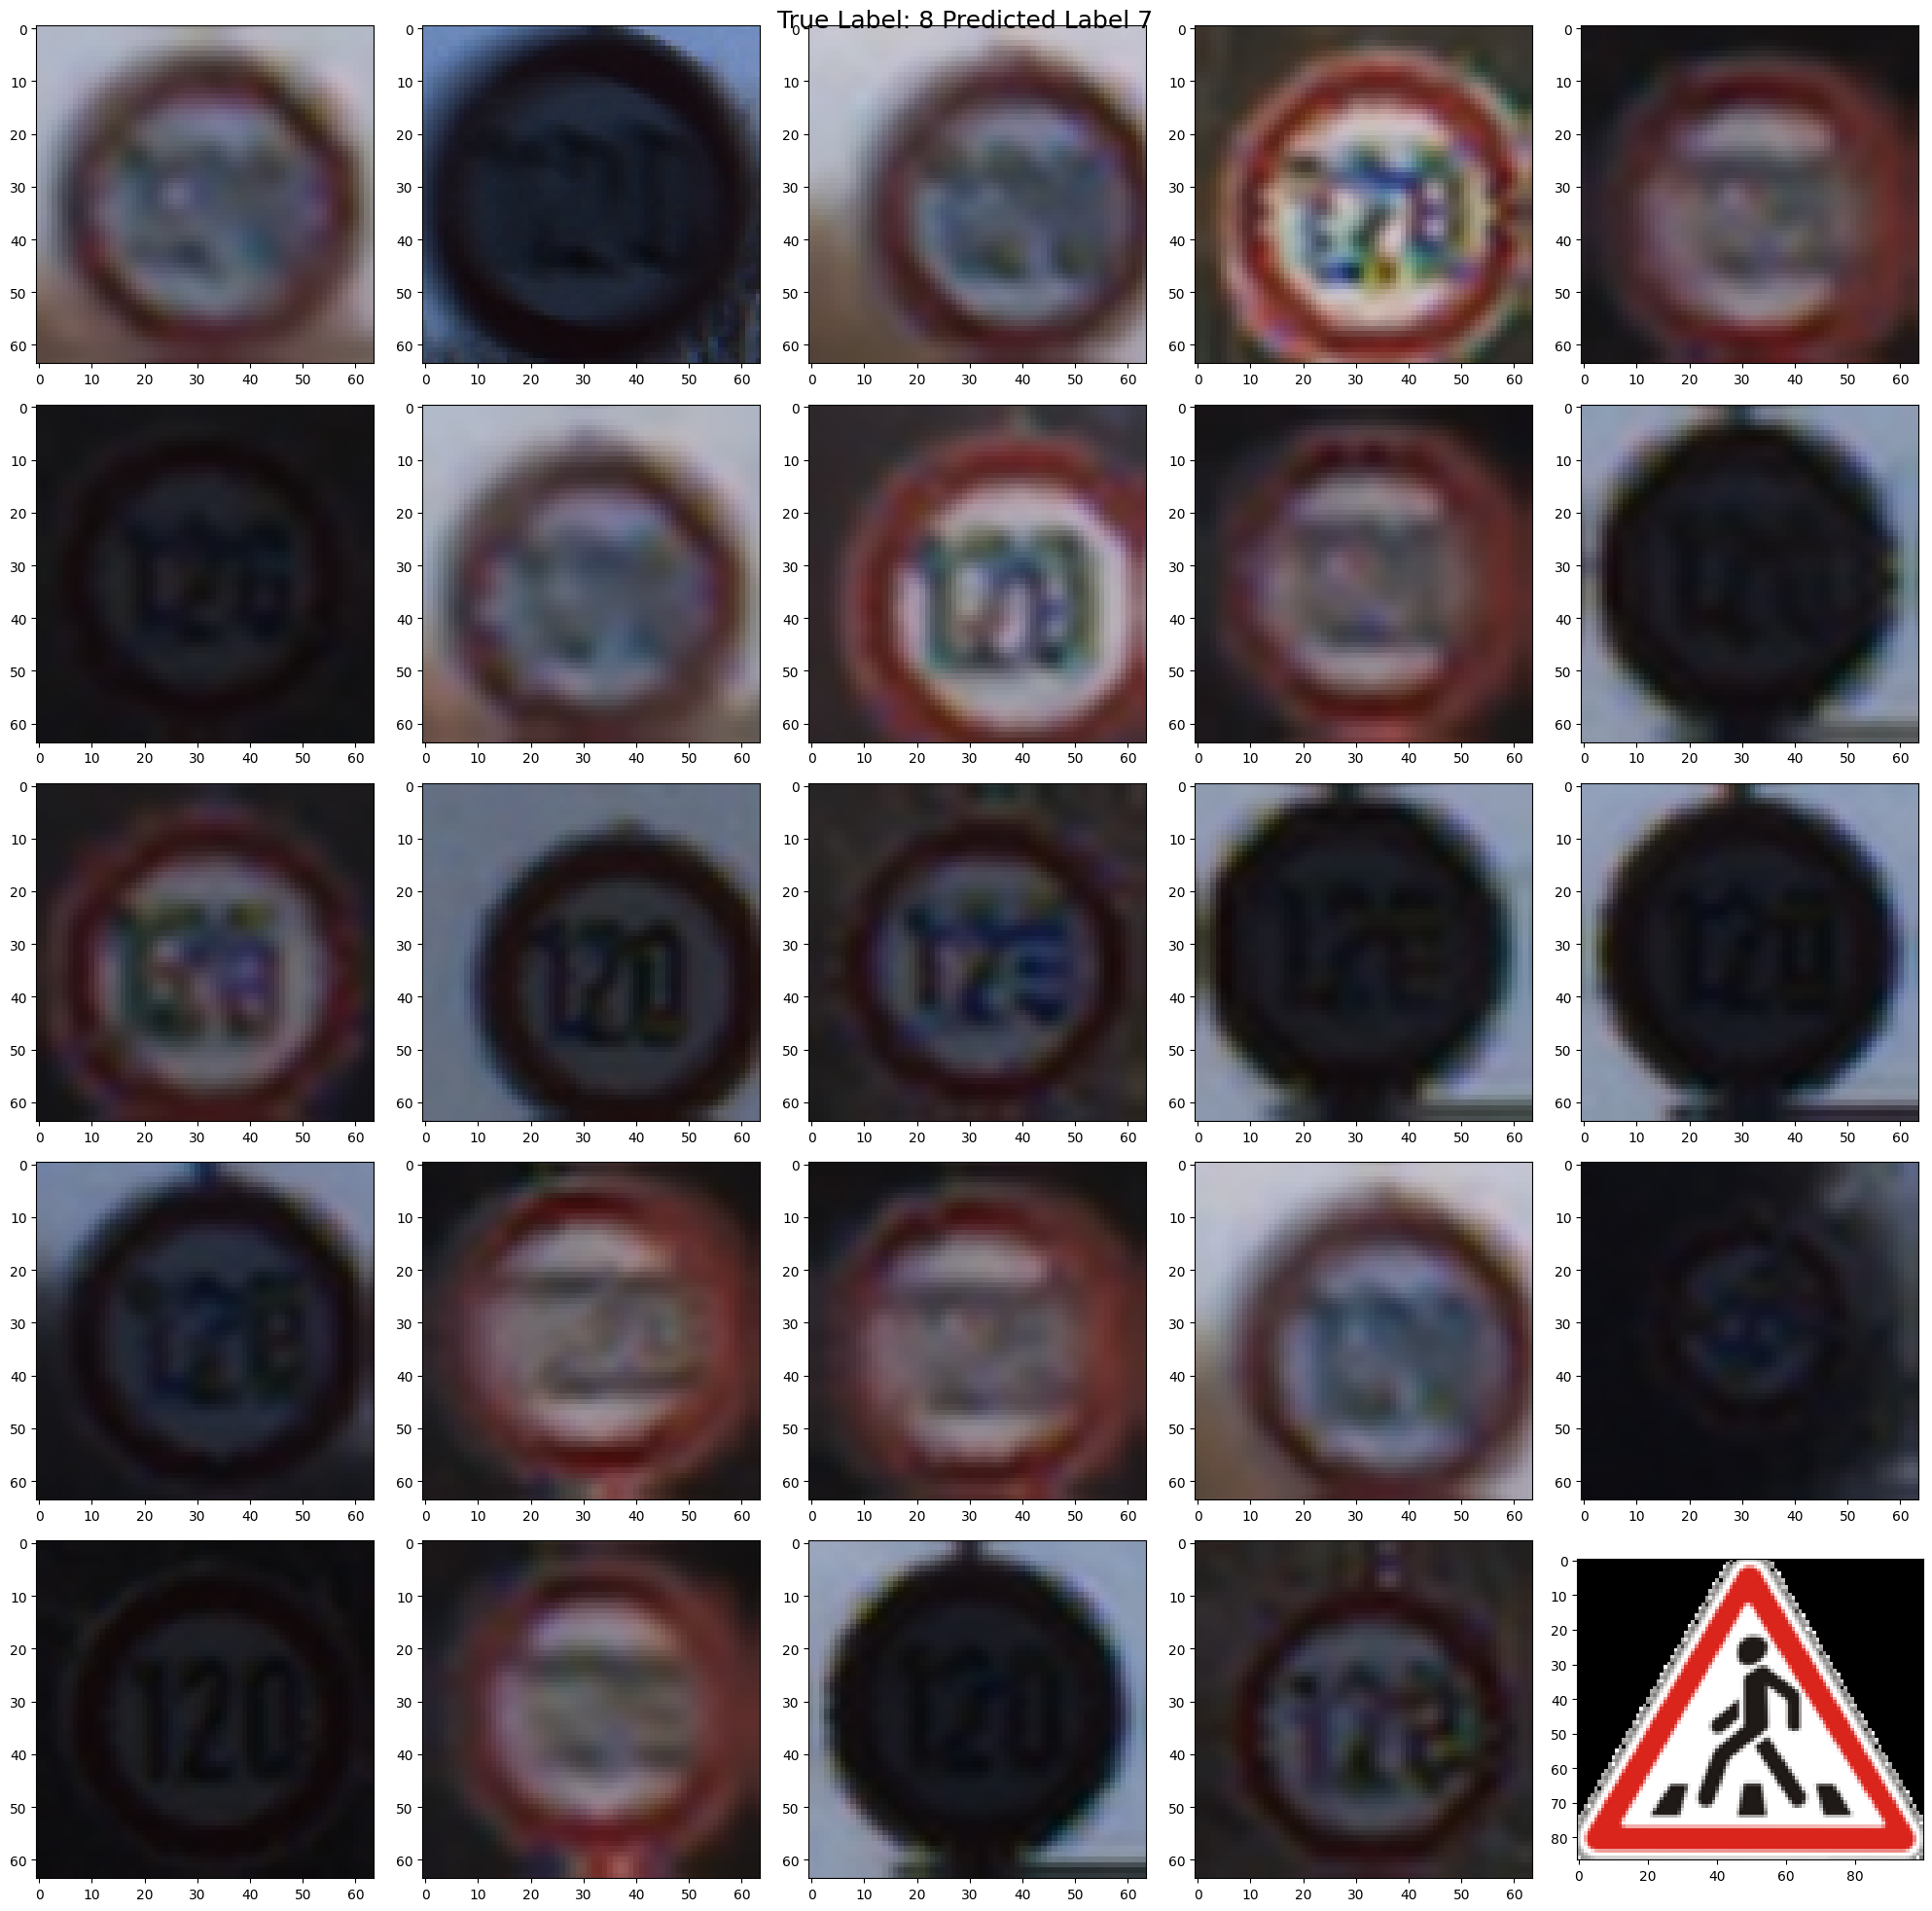

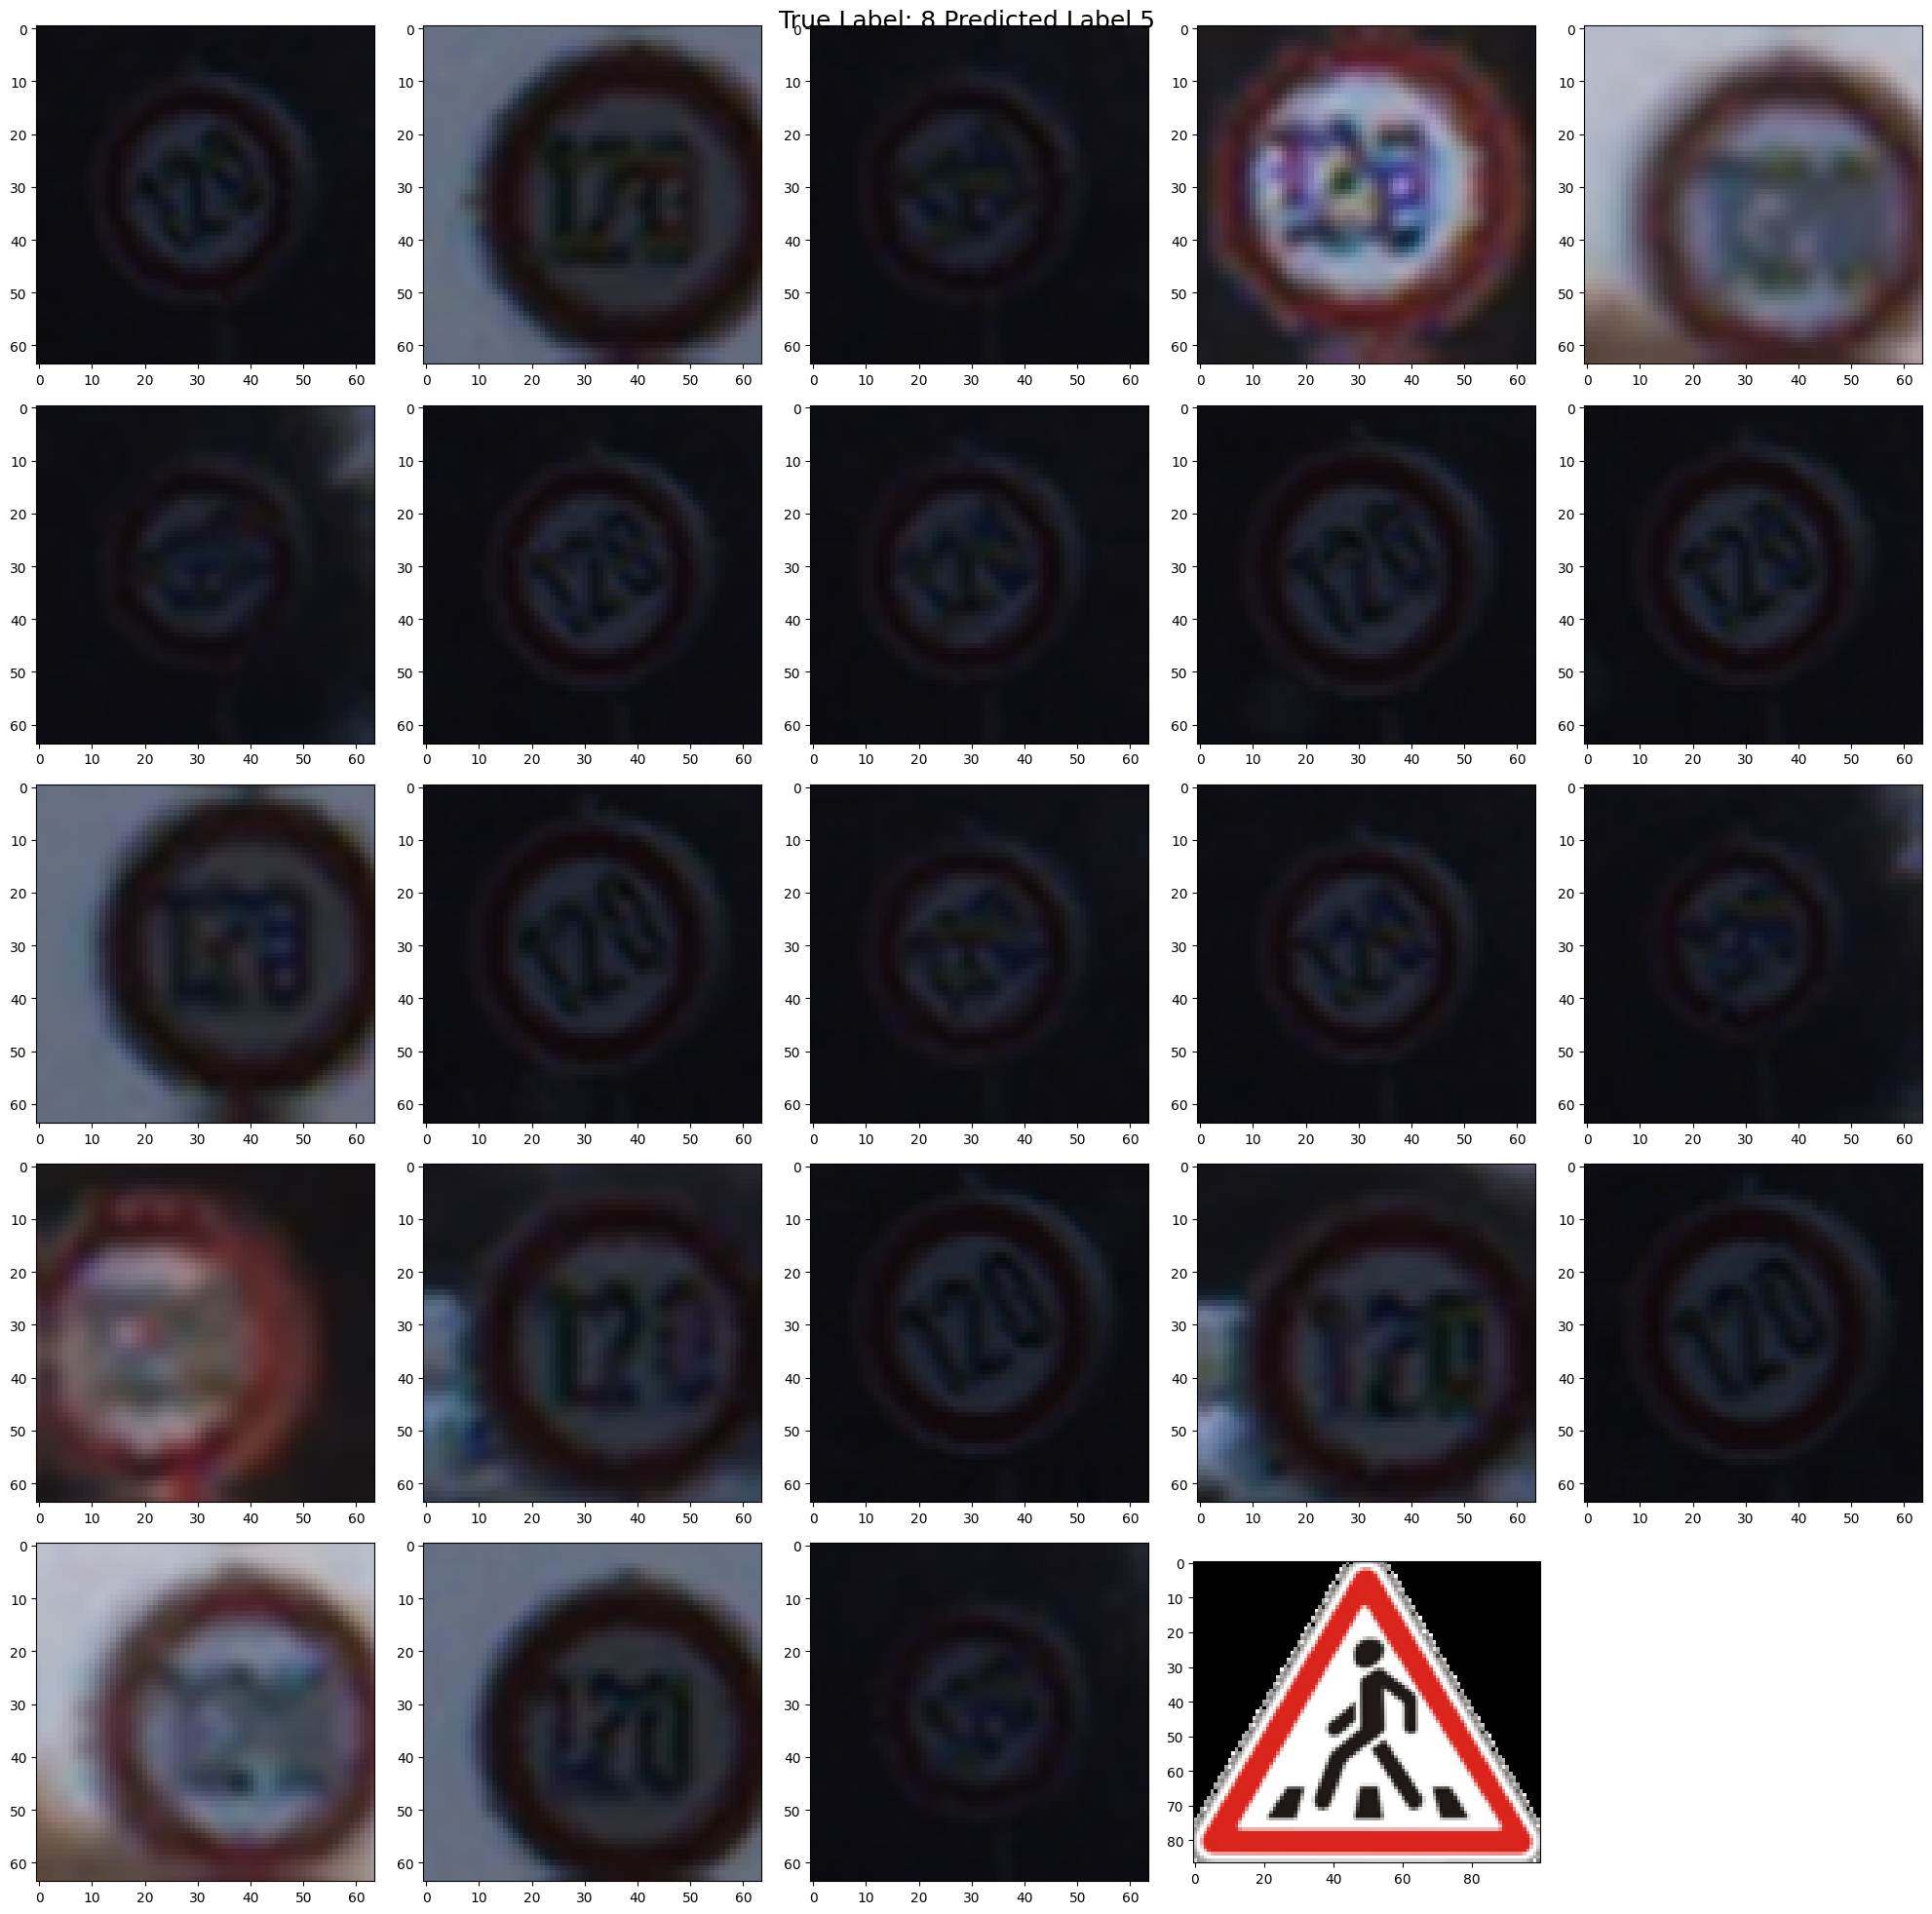

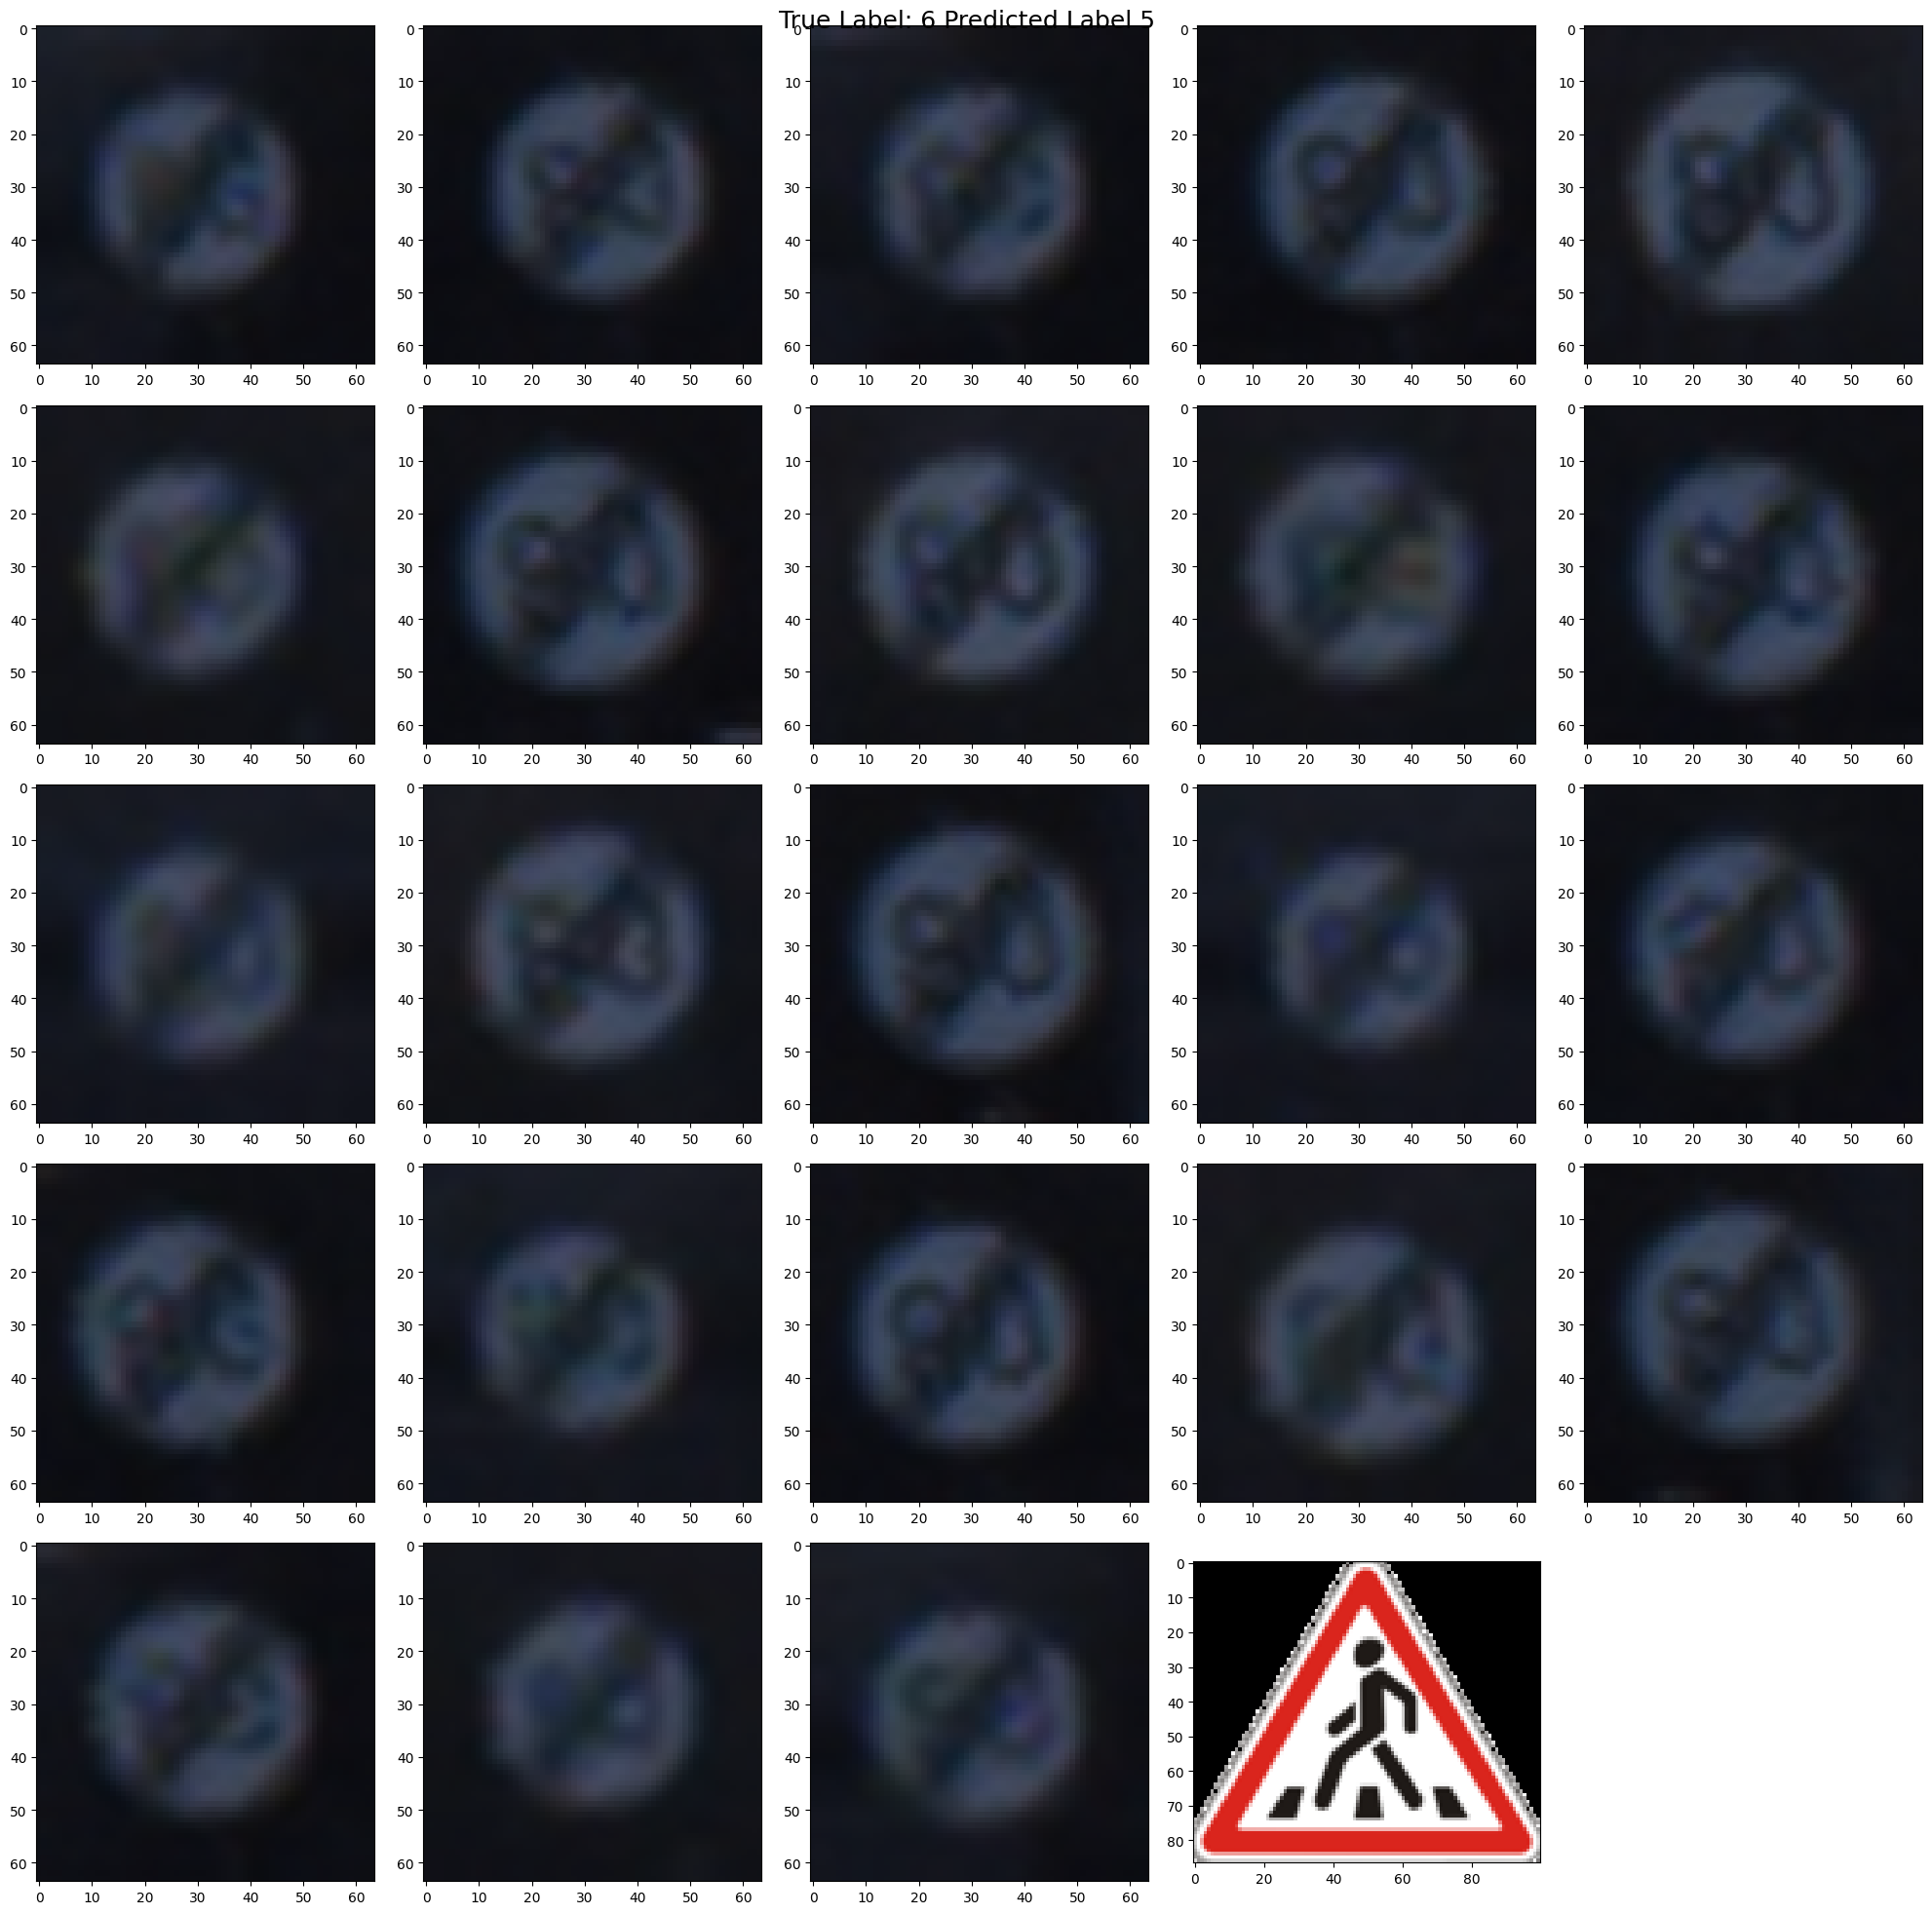

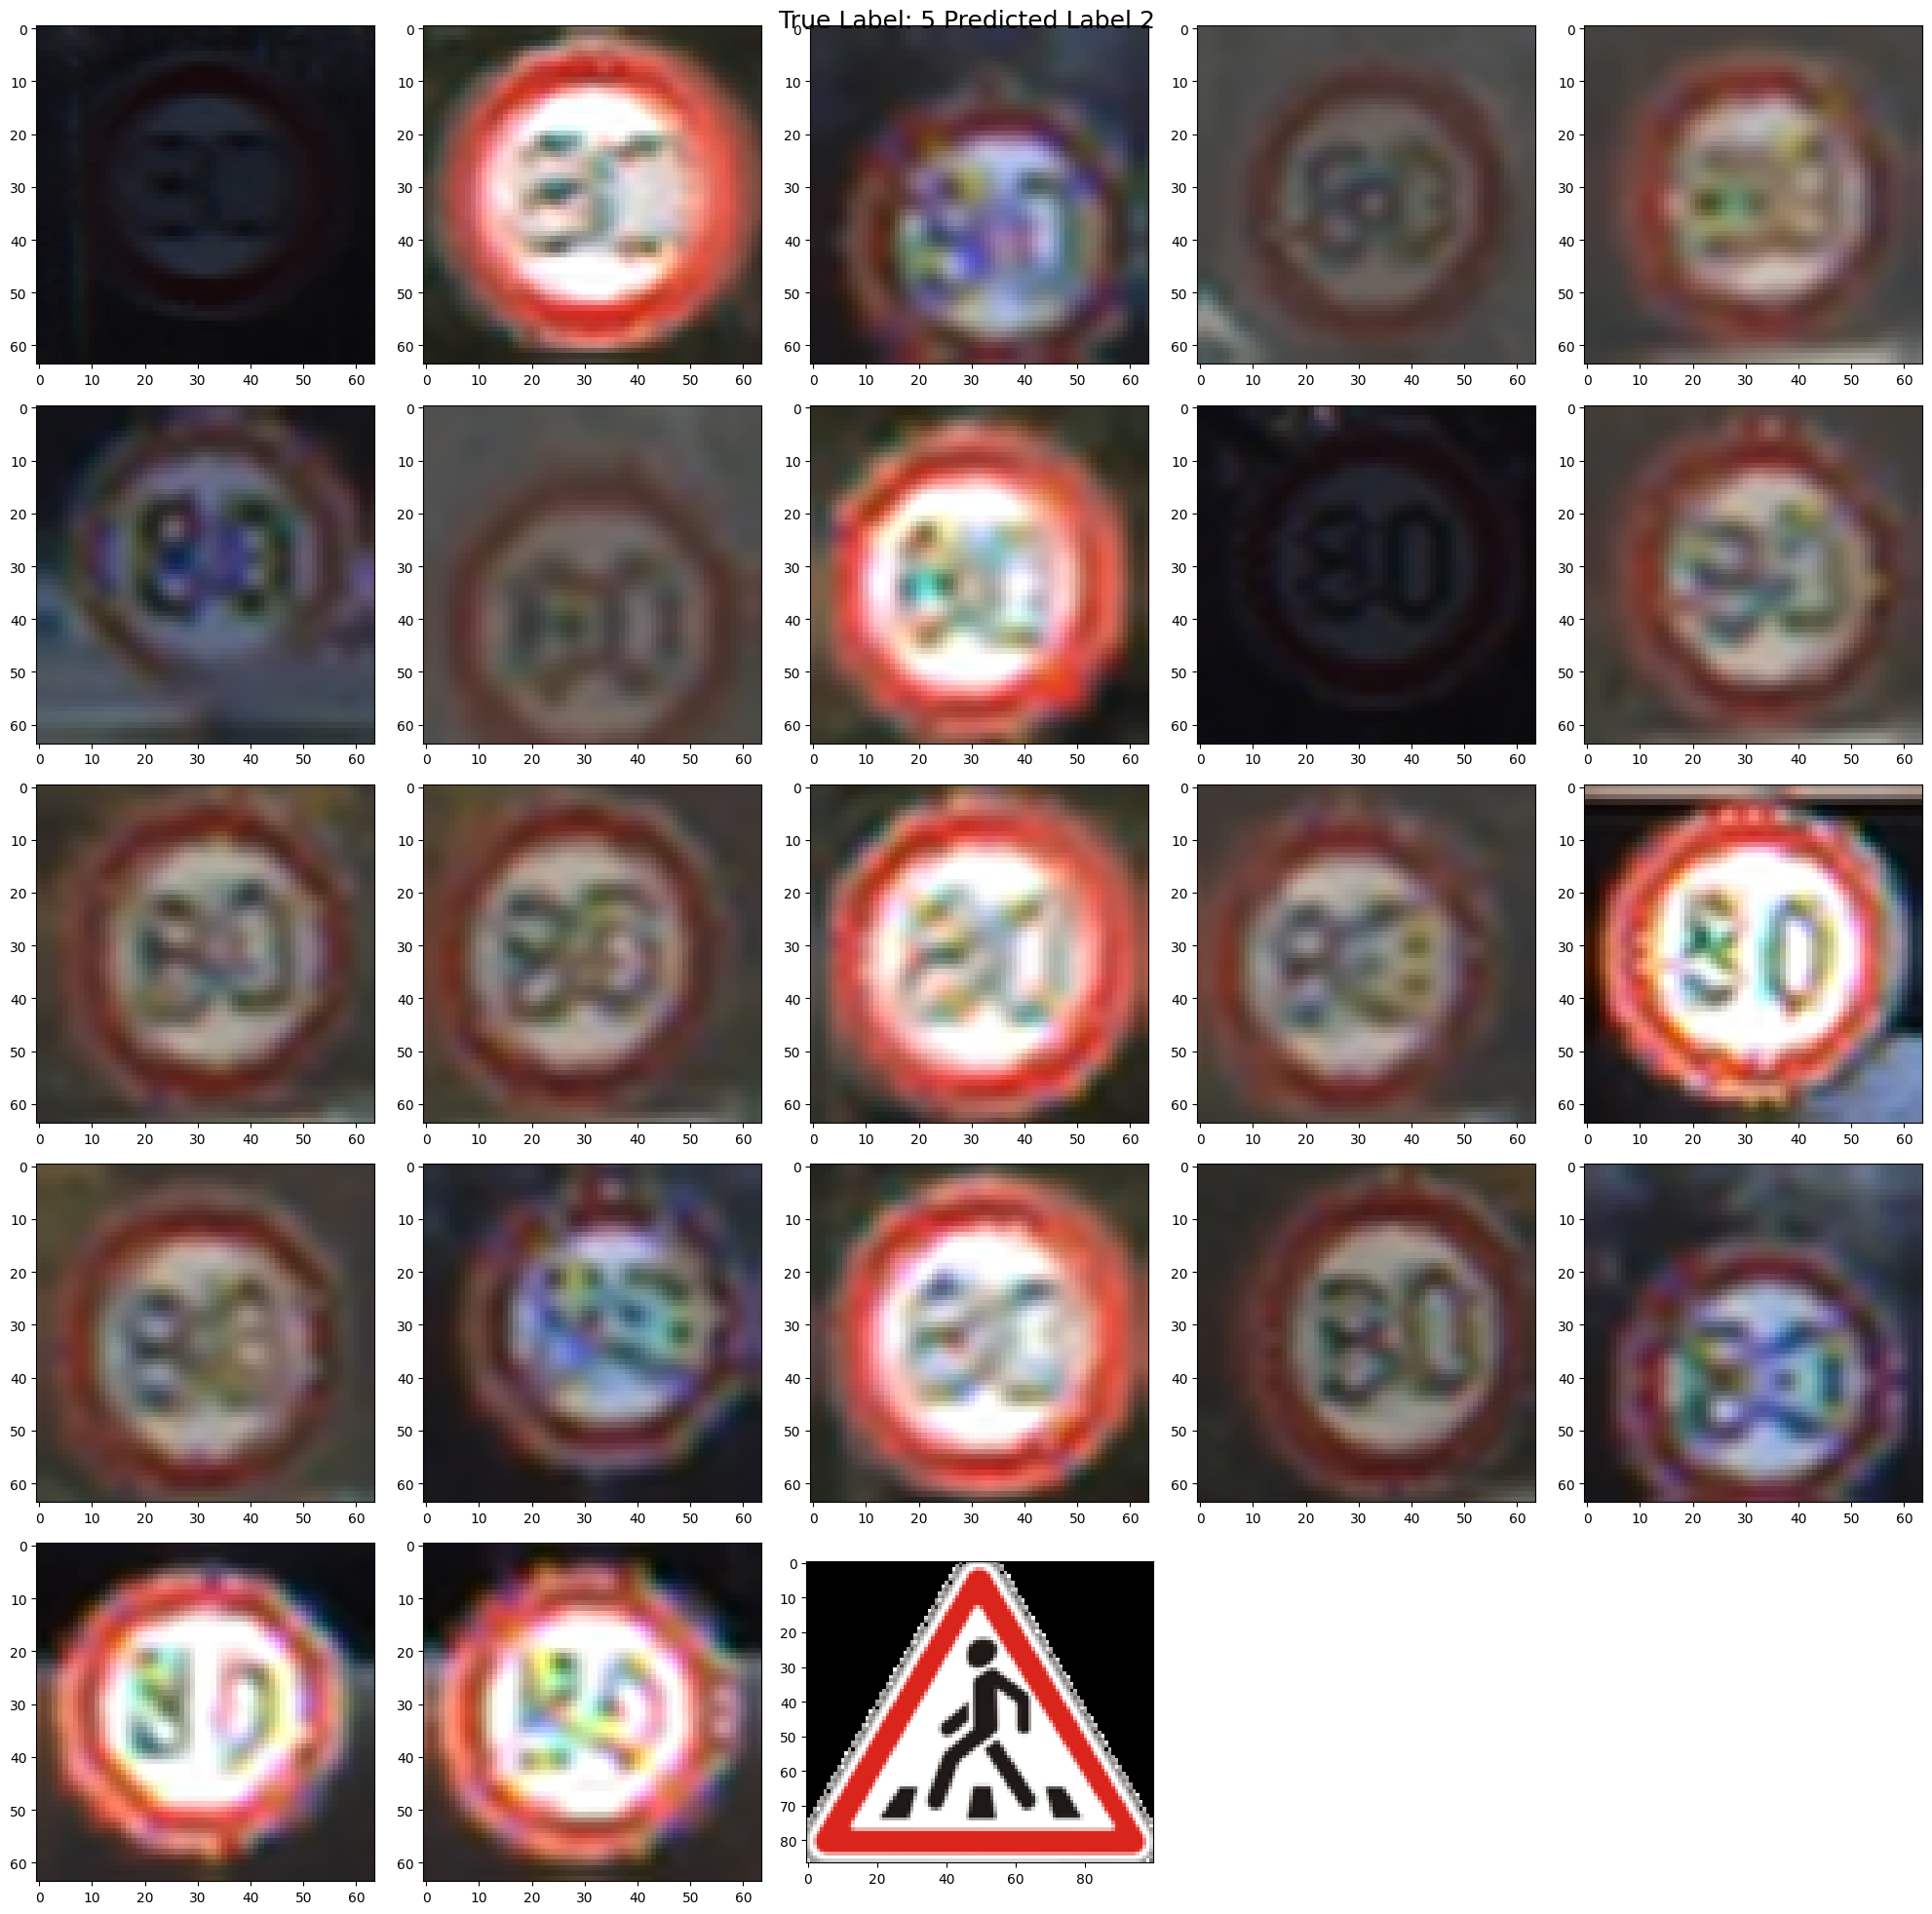

In [18]:
sorted_confused_index_dict = dict(
    sorted(confused_index_dict.items(), key=lambda x: len(x[1]), reverse=True)
)
for i, (labels, index_array) in enumerate(sorted_confused_index_dict.items()):
    images_by_confusion = []
    predicted_image = (
        np.load(BytesIO(meta_df["Meta_Image"]["ClassId" == labels[1]])) * 255.0
    ).astype(np.uint8)
    for current_image_index in index_array:
        images_by_confusion.append(
            ((np.load(BytesIO(test_df["Image"][current_image_index]))) * 255.0).astype(
                np.uint8
            )
        )

    n_row = num_rows = (len(images_by_confusion) + 1) // 5 + (
        (len(images_by_confusion) + 1) % 5 > 0
    )
    n_col = min((len(images_by_confusion) + 1), 5)
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle(f"True Label: {labels[0]} Predicted Label {labels[1]}", fontsize=18)
    for j, c_image in enumerate(images_by_confusion):
        ax = fig.add_subplot(n_row, n_col, j + 1)
        ax.imshow(c_image)
    ax = fig.add_subplot(n_row, n_col, j + 2)
    ax.imshow(predicted_image)
    fig.tight_layout()
    plt.show()
    if i + 1 >= 10:
        break